<a href="https://colab.research.google.com/github/danadascalescu00/FMI/blob/master/EDA/AmazonReviewsSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud
!pip install emoji
!pip install gensim
!pip install transformers

     |████████████████████████████████| 170 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169313 sha256=cea60967c811fe08909685224b58bac3e5de4b956d5e8383ecb47fef222052e7
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 63.8 MB/s 
     |████████████████████████████████| 3.3 MB 44.0 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 68.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 14 18:34:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import re
import sys
import csv
import string
import operator
import functools
import unicodedata

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from matplotlib.ticker import PercentFormatter

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# import pyLDAvis
import gensim

from gensim.summarization.textcleaner import split_sentences

from wordcloud import WordCloud

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, models

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


from transformers import BertTokenizer, BertModel, AdamW

import xgboost as xgb


import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

# Amazon Reviews for Sentiment Analysis

*Sentiment Analysis Classification*: Given a review in plain text, classify the review on a three-point scale (negative, neutral or positive sentiment of a user towards a product).

### Description of the dataset

The **Amazon Reviews** dataset consists of approximately 35 million product reviews from Amazon. The data includes product and user information, ratings, and a plaintext review, which spans a period of 18 years, up to March 2013.

The **Amazon Reviews Full Score** dataset which we will use for the Opinion Mining task is constructed by Xiang Zhang from the above dataset and used as a text classification benchmark in [Zhang et al., Character-level convolutional networks for text classification 2016](https://arxiv.org/abs/1509.01626).

For each review score from 1 to 5, 600,000 training samples and 130,000 testing samples are randomly selected to create the Amazon reviews full score dataset. A total of 3,000,000 training samples and 650,000 testing samples are available.

All of the training samples are stored in the files train.csv and test.csv as comma-separated values. They include three columns, one for each class index (1 – 5), one for the review title, and one for the review text.
Double quotes (") are used to escape the review title and text, and any internal double quotes are separated by two double quotes ("").
A backslash followed by a "n" character, that is "\n", is used to escape newlines.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Load dataset
raw_train_data = pd.read_csv('/content/drive/MyDrive/EDA/train.csv', header = None, nrows = 80000)
raw_test_data = pd.read_csv('/content/drive/MyDrive/EDA/test.csv', header = None, nrows = 20000)

In [ ]:
header = ["Rating", "Title", "Review"]
raw_train_data.columns = header
raw_test_data.columns = header

In [ ]:
raw_train_data.describe(include = "all")

Rating  ...                                             Review
count   80000.000000  ...                                              80000
unique           NaN  ...                                              79958
top              NaN  ...  Radius Technology DVDs ID as "OPTODISC" brand ...
freq             NaN  ...                                                  5
mean        3.036675  ...                                                NaN
std         1.402758  ...                                                NaN
min         1.000000  ...                                                NaN
25%         2.000000  ...                                                NaN
50%         3.000000  ...                                                NaN
75%         4.000000  ...                                                NaN
max         5.000000  ...                                                NaN

[11 rows x 3 columns]

In [ ]:
raw_test_data.describe(include = "all")

Rating  ...                                             Review
count   20000.000000  ...                                              20000
unique           NaN  ...                                              19999
top              NaN  ...  One of Rainbow's best albums, every track is g...
freq             NaN  ...                                                  2
mean        3.012950  ...                                                NaN
std         1.404308  ...                                                NaN
min         1.000000  ...                                                NaN
25%         2.000000  ...                                                NaN
50%         3.000000  ...                                                NaN
75%         4.000000  ...                                                NaN
max         5.000000  ...                                                NaN

[11 rows x 3 columns]

## Data Cleaning

Before further analyzing the dataset, it is necessary to perform some text cleaning and pre-processing steps.


*   Reviews and ratings are the main information in this dataset. If any sample is missing the review or the rating, we will eliminate that row. Missing titles will be replaced with the the text "Missing title". As it can be observed in the previous table, there are missing columns that can negatively influence the outcome of the prediction.
*   Remove any duplicates in the Review column.
*   The text is decoded and then normalized, i.e., the data is transformed from complex symbols into simple characters. Characters can be subjected to different forms of coding, such as “Latin”, “ISO / IEC 8859-1” etc. Therefore, for better analysis, it is necessary to keep the complete data in a standard encoding format. We choose "UTF-8" encoding for this task because it is widely accepted and often recommended.
*   We replace emoticons and emojis with the corresponding descriptive words.
*   Any letter repeated more than three times in a row is replaced by two repetitions of the same letter as the usual rules of English spelling forbid triple letters (for example "cooool" is replaced by "cool").




In [ ]:
raw_train_data = raw_train_data[~raw_train_data["Rating"].isnull()]
raw_train_data = raw_train_data[~raw_train_data["Rating"].isna()]
raw_train_data = raw_train_data[~raw_train_data["Review"].isnull()]
raw_train_data = raw_train_data[~raw_train_data["Review"].isna()]
raw_train_data["Title"] = raw_train_data["Title"].fillna("Missing title")

raw_test_data = raw_test_data[~raw_test_data["Rating"].isnull()]
raw_test_data = raw_test_data[~raw_test_data["Rating"].isna()]
raw_test_data = raw_test_data[~raw_test_data["Review"].isnull()]
raw_test_data = raw_test_data[~raw_test_data["Review"].isna()]
raw_test_data["Title"] = raw_test_data["Title"].fillna("Missing title")

In [ ]:
raw_train_data.dropna(subset = ['Rating', 'Review'], inplace = True)
raw_test_data.dropna(subset = ['Rating', 'Review'], inplace = True)

In [ ]:
raw_train_data.drop_duplicates(subset = ['Review'], inplace = True)
raw_test_data.drop_duplicates(subset = ['Review'], inplace = True)

In [ ]:
raw_train_data.reset_index(drop = True, inplace = True)
raw_test_data.reset_index(drop = True, inplace = True)

In [ ]:
print("Number of training samples: ", len(raw_train_data) - 1)
print("Number of test samples: ", len(raw_test_data) -1)

Number of training samples:  79957
Number of test samples:  19998


In [ ]:
"""
    Emoticons data
"""

from emoji import demojize

EMOTICONS = [
    ("Laughing", r':[‑,-]?\){2,}'),
    ("Rolling_on_the_floor_laughing", r'\=\){2,}|\=\]'),
    ("Heart", r'<3'),
    ("Broken_heart", r'<\\3'),
    ('Very_happy', r':[‑,-]?D'),
    ('Happy_face_or_smiley', r'[:,8,=][‑,-,o,O]?\)|\(\^[v,u,o,O]\^\)|:[‑,-]?3'),
    ('Happy', r'=]'),
    ('Mischievous_smile', r':[‑,-]?>'),
    ('Sticking_tongue_out_playfulness_or_cheekiness', r':P|:[‑,-]P|;P|:b|:-b'),
    ('Kiss', r':[‑,-]?[\*,X,x]'),
    ('Joy', r' uwu | UwU '),
    ('Surprised_or_shock', r':[‑,-]?[o|O|0]|o_O|o_0'),
    ('Sad_frown_andry_or_pouting', r':[‑,-]?\('),
    ('Very_sad', r':[(]{2,}'),
    ('Crying', r':[‑,-]?\'\('),
    ('Straight_face_no_expression_dissaproval_or_not_funny', r':[‑,-]?\|'),
    ('Annoyed_or_hesitant', r'>?[:][\\|\/]|\=\/|=\\'),
    ('Angel_saint_or_innocent', r'[0,O,o]:[‑,-]?[\),3]'),
    ('Embarrassed_or_blushing', r':\$'),
    ('Sad_or_crying', r';_;|\(;_;\)|\(\'_\'\)|Q_Q|\(;_:\)|\(:_;\)'),
    ('Evil_or_devilish', r'[>|}|3]:[‑,-]?\)'),
    ('Laughing_big_grin_or_laugh_with_glasses', r'[:,8,X,=][-,‑]?[D,3]|B\^D'),
    ('Tears_of_happiness', r':[\',\`][‑,-]?\)'),
    ('Horror', r'D[-,‑]\''),
    ('Great_dismay', r'D[8,;,=]'),
    ('Tongue_in_cheek', r':[-,‑]J'),
    ('Yawn', r'8[‑,-]0|>:O'),
    ('Sadness', r'D:'),
    ('Disgust', r'D:<'),
    ('Cool', r'\|;[‑,-]\)'),
    ('Drunk_or_confused', r'%[-,‑]?\)'),
    ('Sealed_lips_or_wearing_braces_or_tongue_tied', r':[-,‑]?[x,#,&]'),
    ('Skeptical_annoyed_undecided_uneasy_or_hesitant', r':[-,‑]?[.,/]|:[L,S]|=[/,L]'),
    ('Scepticism_disbelief_or_disapproval', r'\',:-\||\',:[-,-]'),
    ('Party_all_night', r'#‑\)'),
    ('Headphones_listening_to_music', r'\(\(d\[-_-\]b\)\)'),
    ('Bored', r'\|‑O'),
    ('Dump', r'<:‑\|'),
    ('Being_sick', r':-?#{2,3}..'),
    ('Amazed', r'\(\*_\*\)|\(\+_\+\)|\(\@_\@\)'),
    ('Confusion', r'\(\?_\?\)|\(\・\・?'),
    ('Wink_or_smirk', r';[-,‑]?[\),D,\]]|\*[-,‑]?\)|;\^\)|:‑,|;3'),
    ('Exciting', r'\\\(\^o\^\)\/|\\\(\^o\^\)\／|ヽ\(\^o\^\)丿|\(\*^0^\*\)|＼\(-o-\)／|＼\(~o~\)\／'),
    ('Giggling_with_hand_covering_mouth', r'\^m\^'),
    ('Joyful', r'\(\^_\^\)/|\(\^[O,o]\^\)／|\(°o°\)'),
    ('Tired', r'\(=_=\)'),
    ('Shame', r'\(-_-\)|\(一_一\)'),
    ('Surprised', r'\(o\.o\)'),
    ('Sleeping', r'\(-_-\)zzz'),
    ('Kowtow_as_a_sign_of_respect_or_dogeza_for_apology', r'\(__\)|_\(\._\.\)_|<\(_ _\)>|m\(_ _\)m|m\(__\)m|<m\(__\)m>|_\(_\^_\)_'),
    ('Troubled', r'\(>_<\)>?'),
    ('Nervous__Embarrassed_Troubled_Shy_Sweat_drop', r'\(-_-;\)|\(\^_\^;\)|\(-_-;\)|\(~_~;\)|\(・.・;\)|\(・_・;\)'),
    ('Wink', r'\(\^_-\)'),
    ('Normal_laugh', r'>\^_\^<|<\^!\^>|\(\^\.\^\)|\(\^J\^\)|\(\*\^[_,.]\^\*\)|\(\^<\^\)|\(\^\.\^\)|\(#\^\.\^#\)'),
    ('STH_ELSE', r'.')
]

emoticons_tokens = '|'.join('(?P<%s>%s)' % emoticon for emoticon in EMOTICONS)

def replace_emoticons(text):
    new_text = ""
    for match in re.finditer(emoticons_tokens, text):
        emoticon_name = match.lastgroup
        emoticon = match.group(emoticon_name)
        if emoticon_name == 'STH_ELSE':
            new_text += emoticon
        else:
            new_text += emoticon_name
    return new_text

In [ ]:
raw_train_data["Review"] = raw_train_data["Review"].apply(replace_emoticons)
raw_train_data["Review"] = raw_train_data["Review"].apply(demojize)

raw_test_data["Review"] = raw_test_data["Review"].apply(replace_emoticons)
raw_test_data["Review"] = raw_test_data["Review"].apply(demojize)

In [ ]:
def normalize_text(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore') # remove accented chars
  return x.lower()

raw_train_data["Title"] = raw_train_data["Title"].apply(normalize_text)
raw_train_data["Review"] = raw_train_data["Review"].apply(normalize_text)

raw_test_data["Title"] = raw_test_data["Title"].apply(normalize_text)
raw_test_data["Review"] = raw_test_data["Review"].apply(normalize_text)

In [ ]:
def remove_multiple_occurences(text):
    n = len(text)

    if n < 3:
        return text

    i, count = 0, 0
    while i < n - 1:
        i += 1
        if text[i] != text[i-1]:
            count = 0
        else:
            count += 1
            if count >= 2:
                text = text[:i] + text[i+1:]
                n -= 1
                i -= 1

    return text

raw_train_data["Title"] = raw_train_data["Title"].apply(remove_multiple_occurences)
raw_train_data["Review"] = raw_train_data["Review"].apply(remove_multiple_occurences)

raw_test_data["Title"] = raw_test_data["Title"].apply(remove_multiple_occurences)
raw_test_data["Review"] = raw_test_data["Review"].apply(remove_multiple_occurences)

In [ ]:
raw_train_data.head(10)

Rating  ...                                             Review
0       3  ...  gave this to my dad for a gag gift after direc...
1       5  ...  i hope a lot of people hear this cd. we need m...
2       5  ...  i'm reading a lot of reviews saying that this ...
3       4  ...  the music of yasunori misuda is without questi...
4       5  ...  probably the greatest soundtrack in history! u...
5       5  ...  there's a reason this cd is so expensive, even...
6       1  ...  this is a self-published book, and if you want...
7       4  ...  i was a dissapointed to see errors on the back...
8       1  ...  a complete waste of time. typographical errors...
9       1  ...  i guess you have to be a romance novel lover f...

[10 rows x 3 columns]

In [ ]:
raw_test_data.head(10)

Rating  ...                                             Review
0       1  ...  this model may be ok for sedentary types, but ...
1       4  ...  this is a fast read filled with unexpected hum...
2       2  ...  i bought one of these chargers..the instructio...
3       2  ...  i was excited to find a book ostensibly about ...
4       2  ...  i am a big jvc fan, but i do not like this mod...
5       2  ...  i love the style of this, but after a couple y...
6       2  ...  i cannot scroll through a dvd menu that is set...
7       3  ...  this movie with all of its animals really keep...
8       5  ...  i found a copy of this cookbook at a local use...
9       3  ...  the book is a basic "how to" book for using so...

[10 rows x 3 columns]

#### Descriptive statistics

In [ ]:
raw_train_data.describe(include = "all")

Rating  ...                                             Review
count   79958.000000  ...                                              79958
unique           NaN  ...                                              79958
top              NaN  ...  gave this to my dad for a gag gift after direc...
freq             NaN  ...                                                  1
mean        3.036969  ...                                                NaN
std         1.402735  ...                                                NaN
min         1.000000  ...                                                NaN
25%         2.000000  ...                                                NaN
50%         3.000000  ...                                                NaN
75%         4.000000  ...                                                NaN
max         5.000000  ...                                                NaN

[11 rows x 3 columns]

In [ ]:
raw_test_data.describe(include = "all")

Rating  ...                                             Review
count   19999.000000  ...                                              19999
unique           NaN  ...                                              19999
top              NaN  ...  this model may be ok for sedentary types, but ...
freq             NaN  ...                                                  1
mean        3.012851  ...                                                NaN
std         1.404273  ...                                                NaN
min         1.000000  ...                                                NaN
25%         2.000000  ...                                                NaN
50%         3.000000  ...                                                NaN
75%         4.000000  ...                                                NaN
max         5.000000  ...                                                NaN

[11 rows x 3 columns]

## Data Exploration

#### Exploring relevant features in the data

We will create some additional features that provide relevant information about the composition of our data. In particular, we will analyze the distribution of the textual characteristics regarding the user's review to identify the main insights on the data distribution and find possible outliers.

This step is necessary due to its impact on the final results of the model since it will tell us what type of transformation we need to apply to our data.

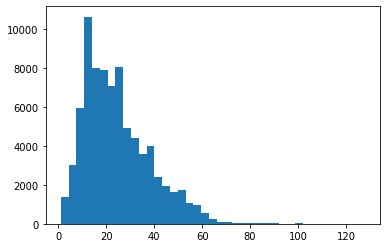

In [ ]:
# Number of characters present in each title in train samples
raw_train_data['Title'].str.len().hist(grid = False, bins = 39)

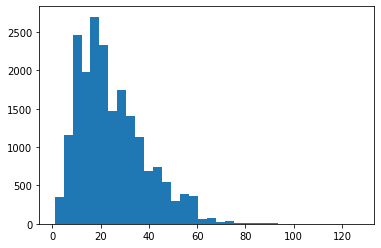

In [ ]:
# Number of characters present in each title in train samples
raw_test_data['Title'].str.len().hist(grid = False, bins = 34)

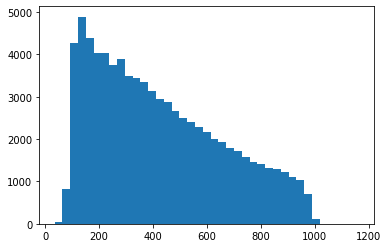

In [ ]:
# Number of characters present in each Review
raw_train_data['Review'].str.len().hist(grid = False, bins = 39)

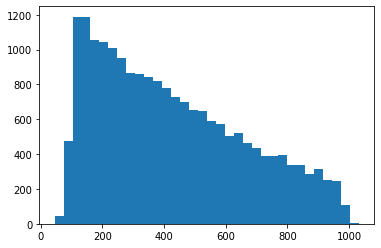

In [ ]:
# Number of characters present in each Review
raw_test_data['Review'].str.len().hist(grid = False, bins = 34)

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
special_characters = '"#$%&\'()*+,-/:;<=>@[\]^_`{|}~ ' + string.digits

In [ ]:
raw_train_data['_Review'] = raw_train_data['Review'].apply(lambda x: x.replace(special_characters, ""))

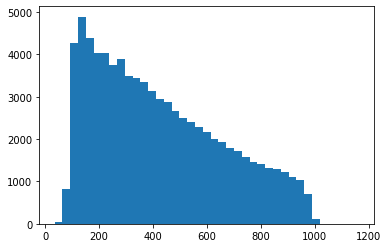

In [ ]:
raw_train_data['_Review'].str.len().hist(grid = False, bins = 39)

In [ ]:
raw_test_data['_Review'] = raw_test_data['Review'].apply(lambda x: x.replace(special_characters, ""))

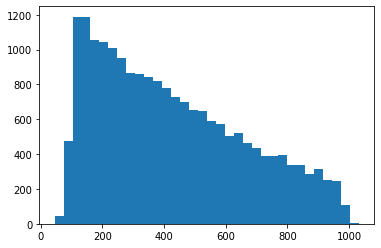

In [ ]:
raw_test_data['_Review'].str.len().hist(grid = False, bins = 34)

Statistical count features that we are going to explore:


*   Total number of characters in text excluding spaces and numbers.
*   Total number of words.
*   Total number of sentences in the reviews.
*   Total number of special (punctuation and numerical) characters.
*   Total number of stopwords in the user's reviews.
*   Number of sentences relative to the total number of words.



In [ ]:
# total numbers of characters
raw_train_data['characters_count_reviews'] = raw_train_data['Review'].apply(lambda x: len(x.replace("\d| |\n", "")))
raw_test_data['characters_count_reviews'] = raw_test_data['Review'].apply(lambda x: len(x.replace("\d| |\n", "")))

raw_train_data['characters_count_title'] = raw_train_data['Title'].apply(lambda x: len(x.replace("\d| |\n", "")))
raw_test_data['characters_count_title'] = raw_test_data['Title'].apply(lambda x: len(x.replace("\d| |\n", "")))

In [ ]:
# total number of words
raw_train_data['words_count_reviews'] = raw_train_data['Review'].apply(lambda x: len(x.split()))
raw_test_data['words_count_reviews'] = raw_test_data['Review'].apply(lambda x: len(x.split()))

raw_train_data['words_count_title'] = raw_train_data['Title'].apply(lambda x: len(x.split()))
raw_test_data['words_count_title'] = raw_test_data['Title'].apply(lambda x: len(x.split()))

In [ ]:
# total number of sentences
raw_train_data['sentences_count'] = raw_train_data['Review'].apply(lambda x: len(split_sentences(x)))
raw_test_data['sentences_count'] = raw_test_data['Review'].apply(lambda x: len(split_sentences(x)))

In [ ]:
# total number of special characters in Reviews
special_characters = string.punctuation + string.digits

# total numbers of characters
raw_train_data['special_chars_count'] = raw_train_data['Review'].apply(lambda x: len(x.replace(special_characters, "")))
raw_test_data['special_chars_count'] = raw_test_data['Review'].apply(lambda x: len(x.replace(special_characters, "")))

In [ ]:
raw_train_data['sentences_density'] = raw_train_data['sentences_count'] / raw_train_data['words_count_reviews']
raw_test_data['sentences_density'] = raw_test_data['sentences_count'] / raw_test_data['words_count_reviews']

In [ ]:
# total number of stopwords in the Reviews

STOPWORDS = set(stopwords.words("english"))

def count_stopwords(text):
  '''
    Return the number of stopwords in the given text.
    Input:
      * text: string
    Output:
      * number of stopwords: integer
  '''
  words_tokens = word_tokenize(text)
  stopwords_tokens = [token for token in words_tokens if token not in STOPWORDS]
  return len(stopwords_tokens)


raw_train_data['stopwords_counts'] = raw_train_data['Review'].apply(lambda x: count_stopwords(x))
raw_test_data['stopwords_counts'] = raw_test_data['Review'].apply(lambda x: count_stopwords(x))

#### Analyze the feature distribution on the plain-text variables


In [ ]:
raw_train_data[['characters_count_reviews', 'characters_count_title', 'words_count_reviews', 'sentences_count', 'special_chars_count', 'sentences_density']].describe()

characters_count_reviews  ...  sentences_density
count              79958.000000  ...       79958.000000
mean                 423.334301  ...           0.068235
std                  239.485309  ...           0.031207
min                   35.000000  ...           0.005348
25%                  220.000000  ...           0.047619
50%                  379.000000  ...           0.063492
75%                  596.000000  ...           0.083333
max                 1164.000000  ...           0.500000

[8 rows x 6 columns]

In [ ]:
raw_test_data[['characters_count_reviews', 'characters_count_title', 'words_count_reviews', 'sentences_count', 'special_chars_count', 'sentences_density']].describe()

characters_count_reviews  ...  sentences_density
count              19999.000000  ...       19999.000000
mean                 424.107755  ...           0.068160
std                  239.279036  ...           0.030758
min                   45.000000  ...           0.004167
25%                  220.000000  ...           0.047619
50%                  381.000000  ...           0.063492
75%                  596.000000  ...           0.083333
max                 1032.000000  ...           0.350000

[8 rows x 6 columns]

The following conclusions can be drawn after viewing the statistical data:

1.   Standard deviations for all the features except for the *number of sentences* are large.
2.   Statistically, both data sets, train and test, have similar characteristics.
3.   Reviews contain on average 5 sentences, 78 words, and 425 characters, which is quite close to the median. But the maximum number of all three characteristics is far from the median that indicates we may deal with some outliers. For example, the maximum number of sentences found in a Review is 37. For now, we will not remove these samples and we will make a decision after a future more detailed analysis.


In [ ]:
new_features = {
    'characters_count_reviews': 'Total number of characters in review excluding spaces and numbers',
    'characters_count_title': 'Total number of characters in title excluding spaces and numbers',
    'words_count_reviews': 'Total number of words in each review',
    'sentences_count': 'Total number of sentences in each review',
    'special_chars_count': 'Total number of special characters in each review',
}

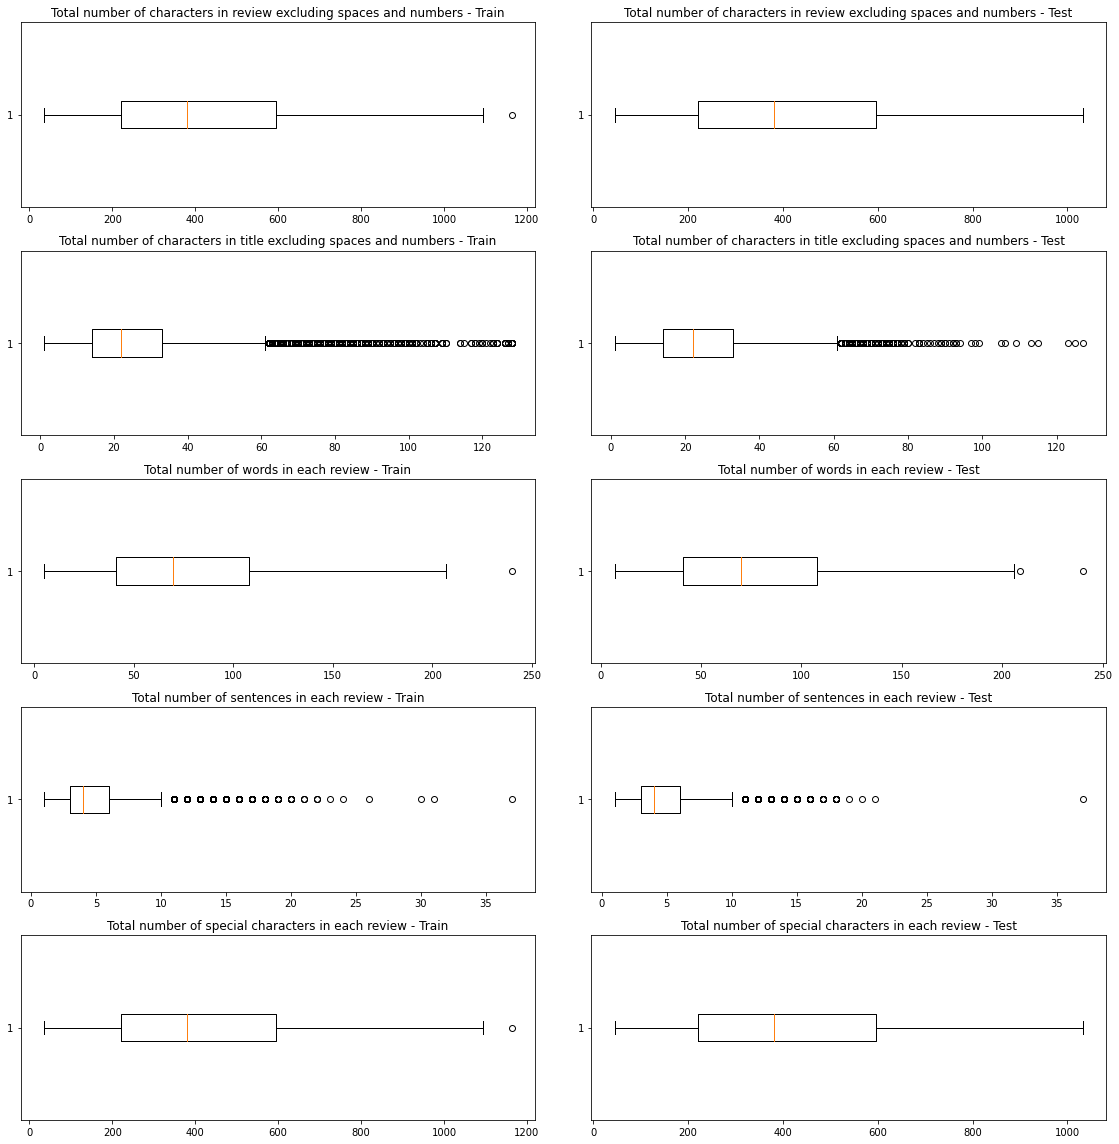

<Figure size 9504x5616 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(int(len(new_features)), 2, figsize = (16, 16))

# Plot a box-plot for each of the new variable (feature)
for idx, feature in enumerate(new_features):
  axes[idx, 0].grid(False)
  axes[idx, 1].grid(False)
  # Set the title
  axes[idx, 0].set_title(new_features[feature] + ' - Train', fontsize = 12)
  axes[idx, 1].set_title(new_features[feature] + ' - Test', fontsize = 12)

  axes[idx, 0].boxplot(raw_train_data[feature], vert = False)
  axes[idx, 1].boxplot(raw_test_data[feature], vert = False)

fig.tight_layout()
plt.figure(figsize = (132, 78))
plt.show()

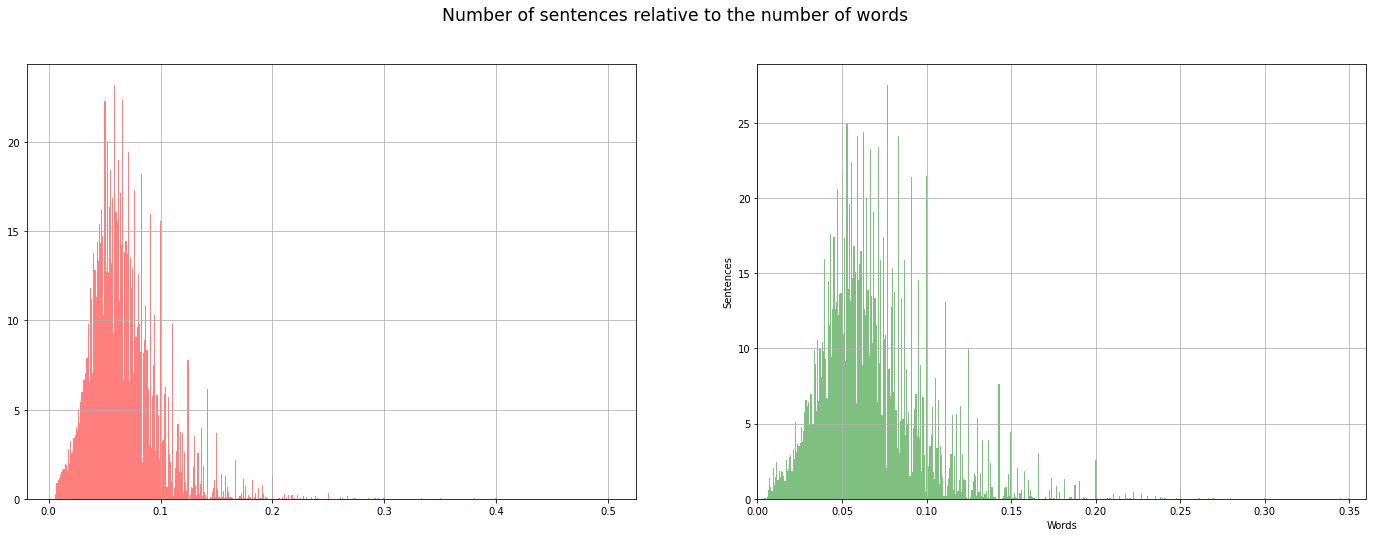

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (24, 8))
axes[0].hist(raw_train_data['sentences_density'], density=True, facecolor='r', alpha=0.5, bins = 500)
axes[0].grid(True)
axes[1].hist(raw_test_data['sentences_density'], density=True, facecolor='g', alpha=0.5, bins = 500)
axes[1].grid(True)

plt.xlabel('Words')
plt.ylabel('Sentences')
plt.suptitle('Number of sentences relative to the number of words', fontsize = 'xx-large')
plt.xlim(0, 0.36)

plt.show()

The *sentences density* is left-skewed with 75% smaller or equal with $ 0.08333333333333333 $ and the maximum value equal to $ 0.350000 $ for the training examples. The visualization of these data made it possible to identify some strange examples. 

### Analyze features related to part-of-speech (POS-tagging)

Another group of features we can inspect in our text data is part-of-speech tagging, also known as word classes or lexical categories. Part-of-speech tagging consists in assigning to each token (word) in a text corpus the part of speech and often other grammatical categories such as tense, number (plural/singular), case, and so on. They are especially used in corpus searches and in-text analysis tools and algorithms.

Reference: https://www.nltk.org/book/ch05.html


In [ ]:
def get_pos_tags(texts):
  df = pd.DataFrame(columns = ['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])

  for text in texts:
    # Extract the part of speech from each review/title
    pos_tags = Counter([j for _, j in nltk.pos_tag(word_tokenize(text), tagset = 'universal')])
    df = df.append(pos_tags, ignore_index = True).fillna(0)

  return df.astype(int)

Inspect part-of-speech tags for reviews' titles.

In [ ]:
df_title_pos_train = get_pos_tags(raw_train_data['Title'].values)
df_title_pos_test = get_pos_tags(raw_test_data['Title'].values)

In [ ]:
df_title_pos_train.describe()

ADJ           ADP  ...             .             X
count  79958.000000  79958.000000  ...  79958.000000  79958.000000
mean       0.731421      0.333300  ...      0.503189      0.006491
std        0.763891      0.570477  ...      0.822601      0.096439
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.000000  ...      0.000000      0.000000
50%        1.000000      0.000000  ...      0.000000      0.000000
75%        1.000000      1.000000  ...      1.000000      0.000000
max        7.000000      6.000000  ...     32.000000      9.000000

[8 rows x 12 columns]

In [ ]:
df_title_pos_test.describe()

ADJ           ADP  ...             .             X
count  19999.000000  19999.000000  ...  19999.000000  19999.000000
mean       0.726436      0.337267  ...      0.508375      0.005600
std        0.763855      0.568629  ...      0.829268      0.080432
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.000000  ...      0.000000      0.000000
50%        1.000000      0.000000  ...      0.000000      0.000000
75%        1.000000      1.000000  ...      1.000000      0.000000
max        6.000000      4.000000  ...     16.000000      3.000000

[8 rows x 12 columns]

In [ ]:
pos_tags_labels = {
    'ADJ': 'Adjective',
    'ADP': 'Adposition',
    'ADV': 'Adverb',
    'CONJ': 'Conjuction',
    'DET': 'Determiner/Article',
    'NOUN': 'Noun',
    'NUM': 'Numeral',
    'PRT': 'Particle',
    'PRON': 'Pronoun',
    'VERB': 'Verb',
    '.': 'Punctuation mark',
    'X': 'Other'
}

Train data:

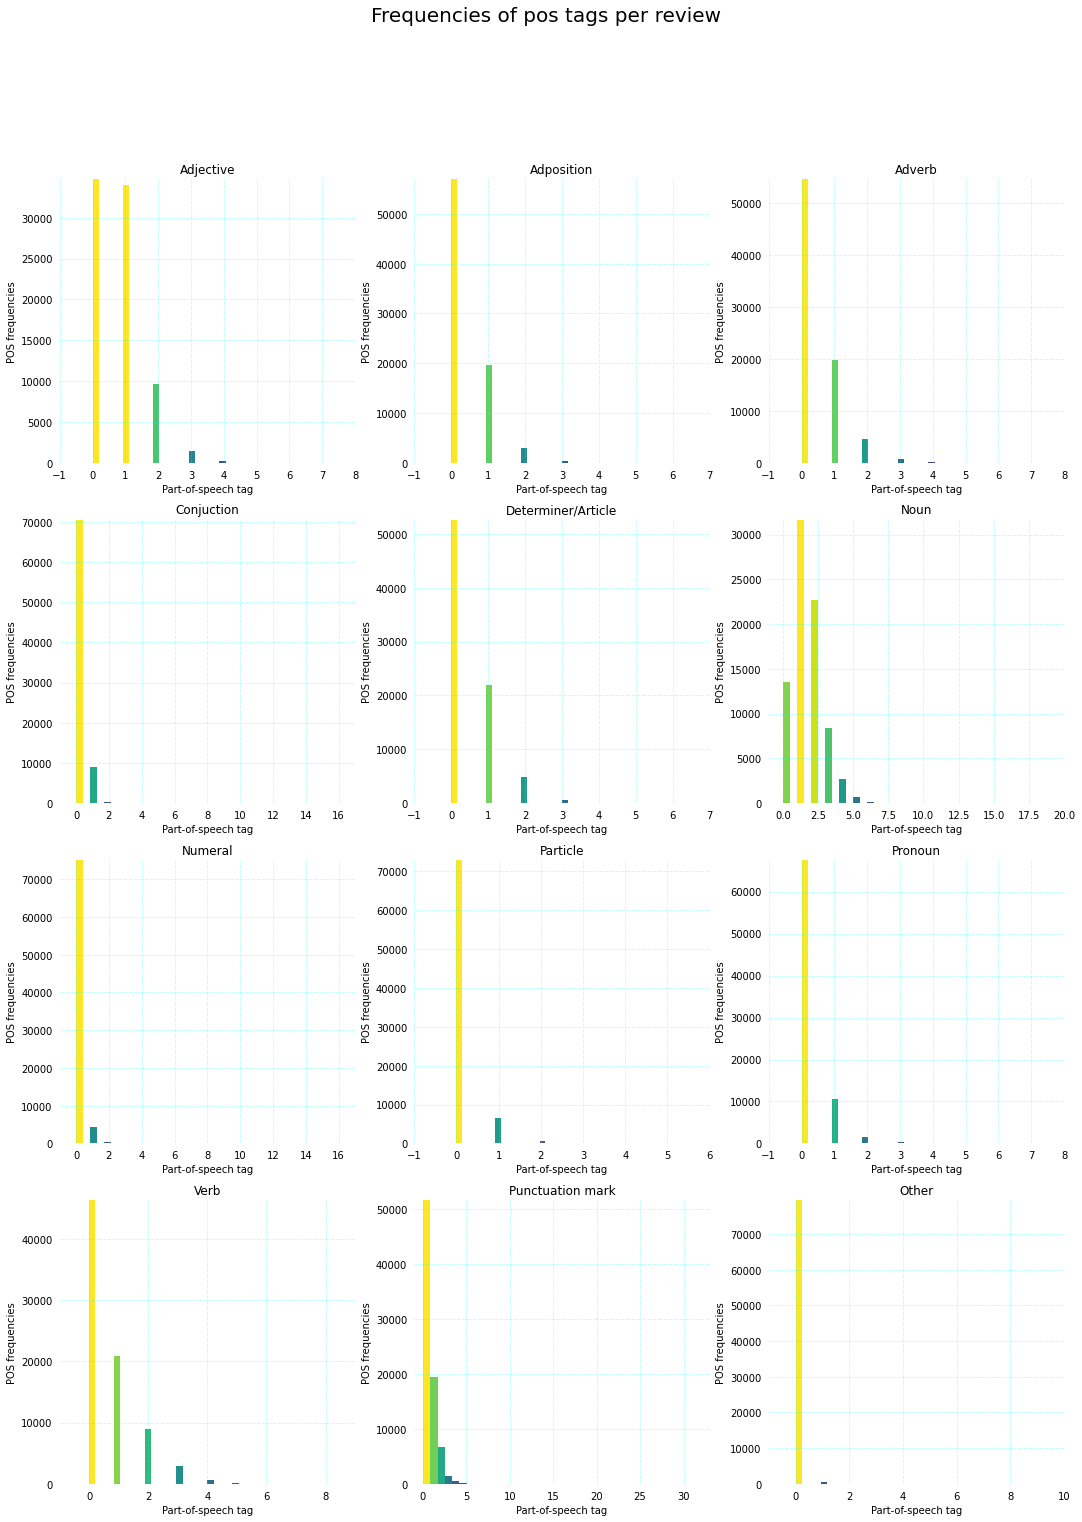

In [ ]:
fig, axes = plt.subplots(int(len(pos_tags_labels) / 3), 3, figsize = (18, 24), tight_layout = False)

for nrow in range(int(len(pos_tags_labels) / 3)):
  for ncol in range(3):
    # Remove axes spines
    for spine in ['right', 'bottom', 'left', 'top']:
      axes[nrow, ncol].spines[spine].set_visible(False)

    # Remove x, y ticks
    axes[nrow, ncol].xaxis.set_ticks_position('none')
    axes[nrow, ncol].yaxis.set_ticks_position('none')

    # Add gridlines
    axes[nrow, ncol].grid(b = True,
                          color = 'cyan',
                          linestyle = '-.',
                          linewidth = 0.5,
                          alpha = 0.5)

fig.suptitle('Frequencies of pos tags per review', fontsize = 20)
for idx, (label, title) in enumerate(pos_tags_labels.items()):
  N, lower_limit, patches = axes[int(idx / 3), int(idx % 3)].hist(df_title_pos_train[label], bins = 38)

  fracs = ((N ** (1 / 4)) / N.max())
  norm = colors.Normalize(fracs.min(), fracs.max())
  
  for current_frac, current_patch in zip(fracs, patches):
      color = plt.cm.viridis(norm(current_frac))
      current_patch.set_facecolor(color)
  
  axes[int(idx / 3), int(idx % 3)].set_title(title)
  axes[int(idx / 3), int(idx % 3)].set_xlabel('Part-of-speech tag')
  axes[int(idx / 3), int(idx % 3)].set_ylabel('POS frequencies')

  axes[int(idx / 3), int(idx % 3)].set_xlim([df_title_pos_train[label].min() - 1, df_title_pos_train[label].max() + 1])
  axes[int(idx / 3), int(idx % 3)].set_ylim([N.min(), N.max() + 5])


Test data:

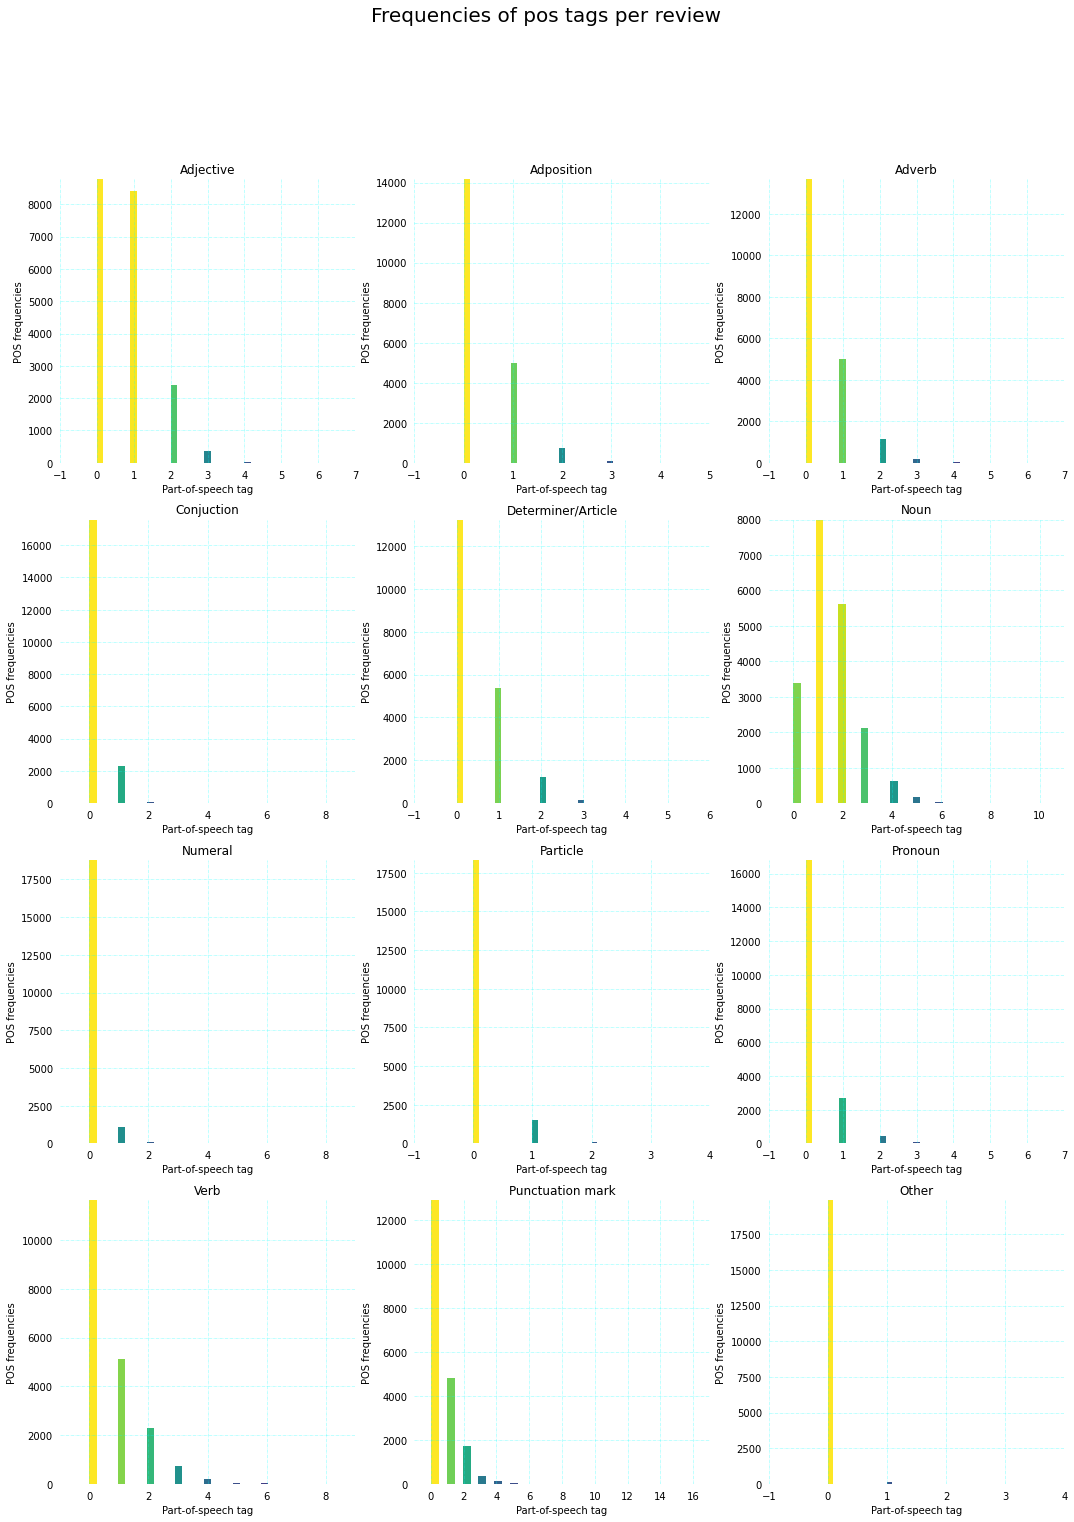

In [ ]:
fig, axes = plt.subplots(int(len(pos_tags_labels) / 3), 3, figsize = (18, 24), tight_layout = False)

for nrow in range(int(len(pos_tags_labels) / 3)):
  for ncol in range(3):
    # Remove axes spines
    for spine in ['right', 'bottom', 'left', 'top']:
      axes[nrow, ncol].spines[spine].set_visible(False)

    # Remove x, y ticks
    axes[nrow, ncol].xaxis.set_ticks_position('none')
    axes[nrow, ncol].yaxis.set_ticks_position('none')

    # Add gridlines
    axes[nrow, ncol].grid(b = True,
                          color = 'cyan',
                          linestyle = '-.',
                          linewidth = 0.5,
                          alpha = 0.5)

fig.suptitle('Frequencies of pos tags per review', fontsize = 20)
for idx, (label, title) in enumerate(pos_tags_labels.items()):
  N, lower_limit, patches = axes[int(idx / 3), int(idx % 3)].hist(df_title_pos_test[label], bins = 33)

  fracs = ((N ** (1 / 4)) / N.max())
  norm = colors.Normalize(fracs.min(), fracs.max())
  
  for thisfrac, thispatch in zip(fracs, patches):
      color = plt.cm.viridis(norm(thisfrac))
      thispatch.set_facecolor(color)
  
  axes[int(idx / 3), int(idx % 3)].set_title(title)
  axes[int(idx / 3), int(idx % 3)].set_xlabel('Part-of-speech tag')
  axes[int(idx / 3), int(idx % 3)].set_ylabel('POS frequencies')

  axes[int(idx / 3), int(idx % 3)].set_xlim([df_title_pos_test[label].min() - 1, df_title_pos_test[label].max() + 1])
  axes[int(idx / 3), int(idx % 3)].set_ylim([N.min(), N.max() + 5])


Inspect part-of-speech tags for reviews' content.

In [ ]:
df_review_pos_train = get_pos_tags(raw_train_data['Review'].values)
df_review_pos_test = get_pos_tags(raw_test_data['Review'].values)

In [ ]:
df_review_pos_train.describe()

ADJ           ADP  ...             .             X
count  79958.000000  79958.000000  ...  79958.000000  79958.000000
mean       7.936367      8.326922  ...      9.362228      0.077303
std        5.102445      5.590783  ...      6.511921      0.542861
min        0.000000      0.000000  ...      0.000000      0.000000
25%        4.000000      4.000000  ...      4.000000      0.000000
50%        7.000000      7.000000  ...      8.000000      0.000000
75%       11.000000     12.000000  ...     13.000000      0.000000
max       35.000000     34.000000  ...     86.000000     41.000000

[8 rows x 12 columns]

In [ ]:
df_review_pos_test.describe()

ADJ           ADP  ...             .             X
count  19999.000000  19999.000000  ...  19999.000000  19999.000000
mean       7.918146      8.342767  ...      9.398670      0.085304
std        5.098613      5.587118  ...      6.787793      0.607586
min        0.000000      0.000000  ...      0.000000      0.000000
25%        4.000000      4.000000  ...      4.000000      0.000000
50%        7.000000      7.000000  ...      8.000000      0.000000
75%       11.000000     12.000000  ...     13.000000      0.000000
max       81.000000     33.000000  ...    250.000000     41.000000

[8 rows x 12 columns]

Train data:

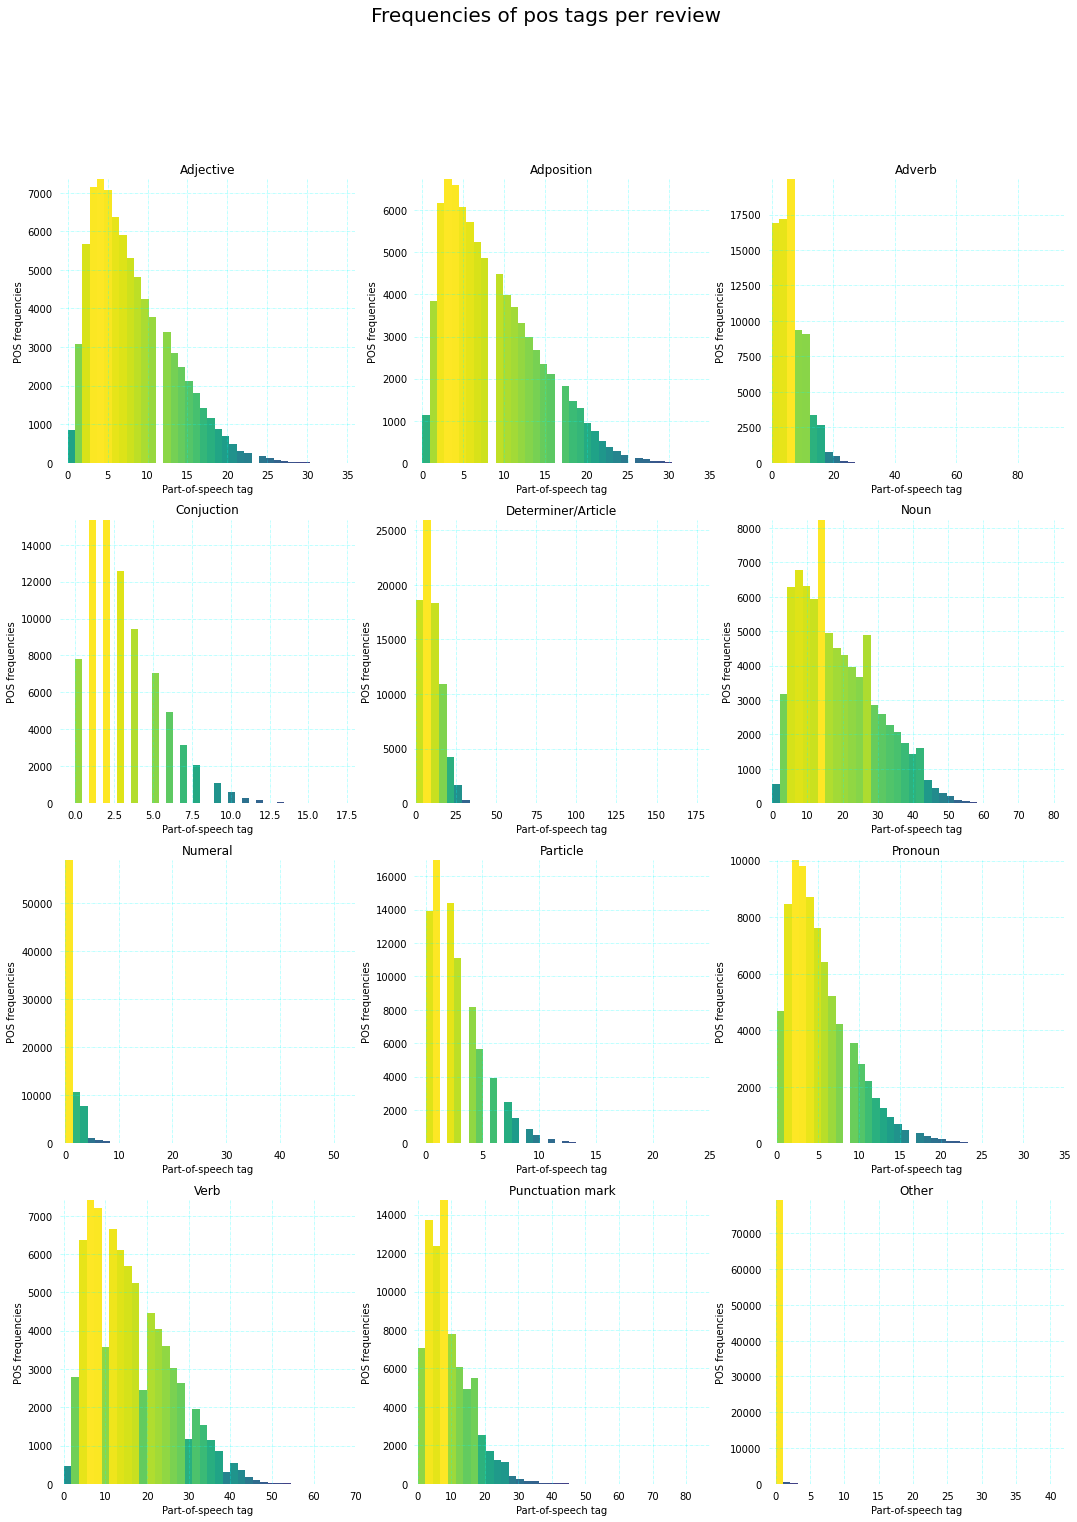

In [ ]:
fig, axes = plt.subplots(int(len(pos_tags_labels) / 3), 3, figsize = (18, 24), tight_layout = False)

for nrow in range(int(len(pos_tags_labels) / 3)):
  for ncol in range(3):
    # Remove axes spines
    for spine in ['right', 'bottom', 'left', 'top']:
      axes[nrow, ncol].spines[spine].set_visible(False)

    # Remove x, y ticks
    axes[nrow, ncol].xaxis.set_ticks_position('none')
    axes[nrow, ncol].yaxis.set_ticks_position('none')

    # Add gridlines
    axes[nrow, ncol].grid(b = True,
                          color = 'cyan',
                          linestyle = '-.',
                          linewidth = 0.5,
                          alpha = 0.5)

fig.suptitle('Frequencies of pos tags per review', fontsize = 20)
for idx, (label, title) in enumerate(pos_tags_labels.items()):
  N, lower_limit, patches = axes[int(idx / 3), int(idx % 3)].hist(df_review_pos_train[label], bins = 38)

  fracs = ((N ** (1 / 4)) / N.max())
  norm = colors.Normalize(fracs.min(), fracs.max())
  
  for thisfrac, thispatch in zip(fracs, patches):
      color = plt.cm.viridis(norm(thisfrac))
      thispatch.set_facecolor(color)
  
  axes[int(idx / 3), int(idx % 3)].set_title(title)
  axes[int(idx / 3), int(idx % 3)].set_xlabel('Part-of-speech tag')
  axes[int(idx / 3), int(idx % 3)].set_ylabel('POS frequencies')

  axes[int(idx / 3), int(idx % 3)].set_xlim([df_review_pos_train[label].min() - 1, df_review_pos_train[label].max() + 1])
  axes[int(idx / 3), int(idx % 3)].set_ylim([N.min(), N.max() + 5])


Test data:

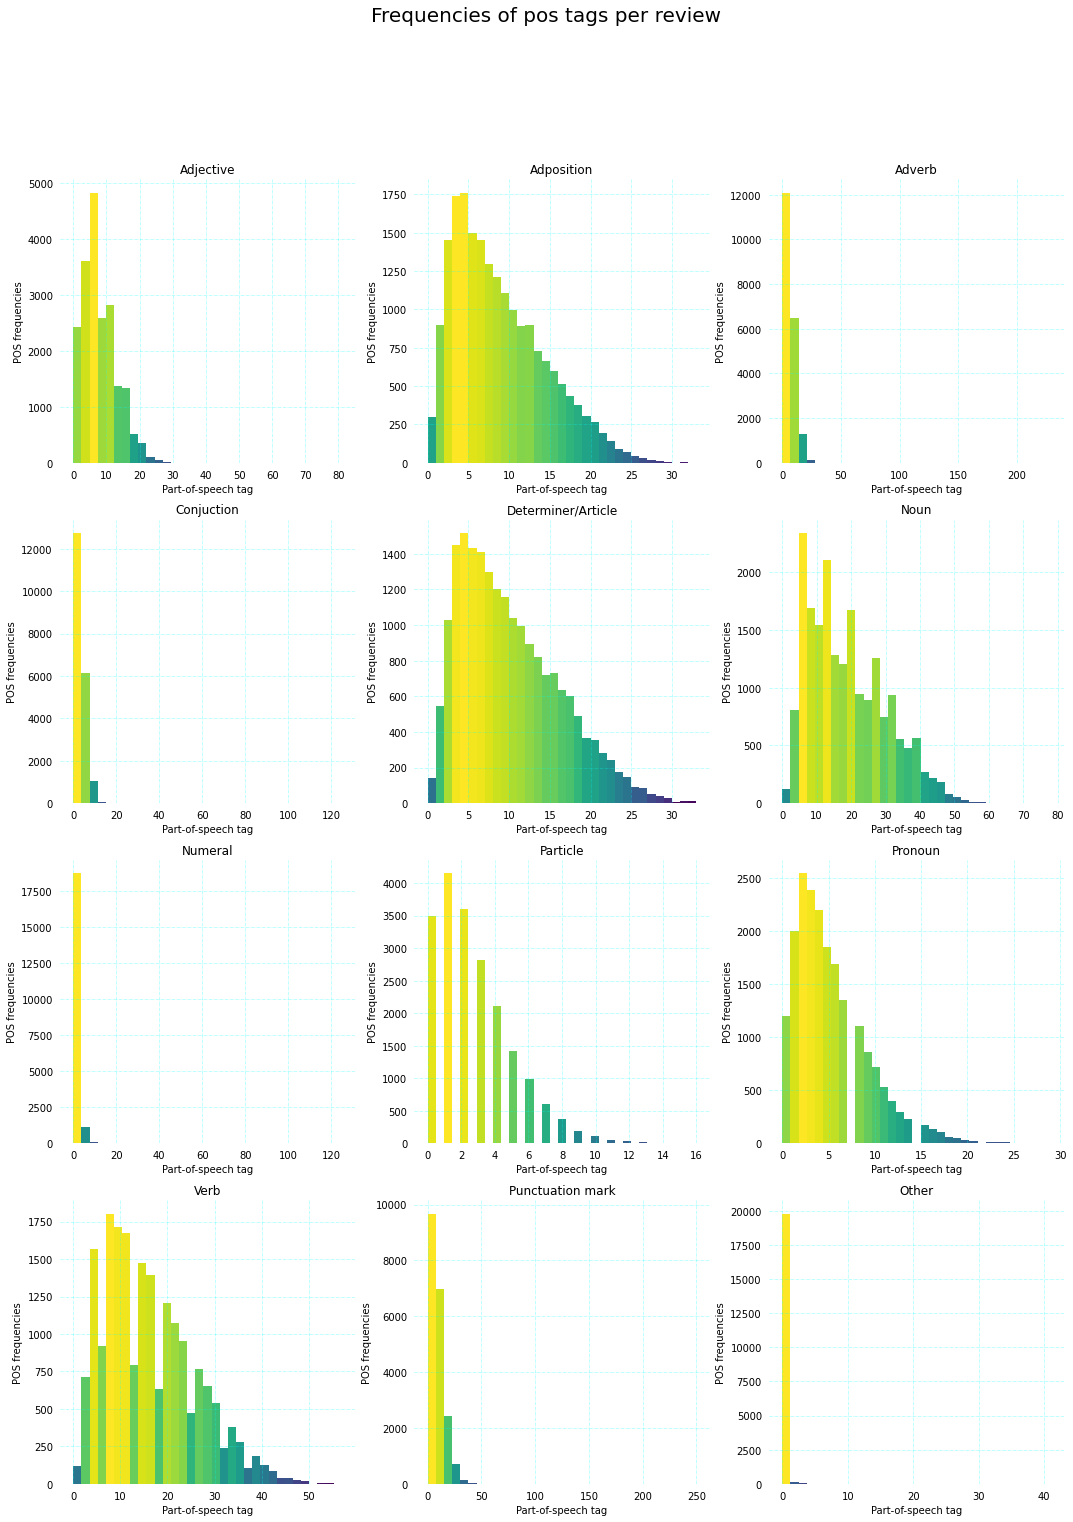

In [ ]:
fig, axes = plt.subplots(int(len(pos_tags_labels) / 3), 3, figsize = (18, 24), tight_layout = False)

for nrow in range(int(len(pos_tags_labels) / 3)):
  for ncol in range(3):
    # Remove axes spines
    for spine in ['right', 'bottom', 'left', 'top']:
      axes[nrow, ncol].spines[spine].set_visible(False)

    # Remove x, y ticks
    axes[nrow, ncol].xaxis.set_ticks_position('none')
    axes[nrow, ncol].yaxis.set_ticks_position('none')

    # Add gridlines
    axes[nrow, ncol].grid(b = True,
                          color = 'cyan',
                          linestyle = '-.',
                          linewidth = 0.5,
                          alpha = 0.5)

fig.suptitle('Frequencies of pos tags per review', fontsize = 20)
for idx, (label, title) in enumerate(pos_tags_labels.items()):
  N, lower_limit, patches = axes[int(idx / 3), int(idx % 3)].hist(df_review_pos_test[label], bins = 33)

  fracs = ((N ** (1 / 4)) / N.max())
  norm = colors.Normalize(fracs.min(), fracs.max())
  
  for thisfrac, thispatch in zip(fracs, patches):
      color = plt.cm.viridis(norm(thisfrac))
      thispatch.set_facecolor(color)
  
  axes[int(idx / 3), int(idx % 3)].set_title(title)
  axes[int(idx / 3), int(idx % 3)].set_xlabel('Part-of-speech tag')
  axes[int(idx / 3), int(idx % 3)].set_ylabel('POS frequencies')


### Check for unkown words in the vocabulary

### Visualise top words, bigrams and trigrams

#### Most frequent words excluding stopwords.

In [ ]:
def clean_tokenize_text(text, stopwords):
  new_text = re.sub(r'/\W+/g', '', text)
  tokens = word_tokenize(text)
  new_text = ' '.join([token.strip() for token in tokens if token.strip() not in stopwords])
  return new_text

In [ ]:
train_titles_preprocessed = raw_train_data['Title'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))

In [ ]:
test_titles_preprocessed = raw_test_data['Title'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))

In [ ]:
train_reviews_preprocessed = raw_train_data['Review'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))

In [ ]:
test_reviews_preprocessed = raw_test_data['Review'].apply(lambda x: clean_tokenize_text(x, STOPWORDS))

WordCloud for Reviews' titles

*  Train data:

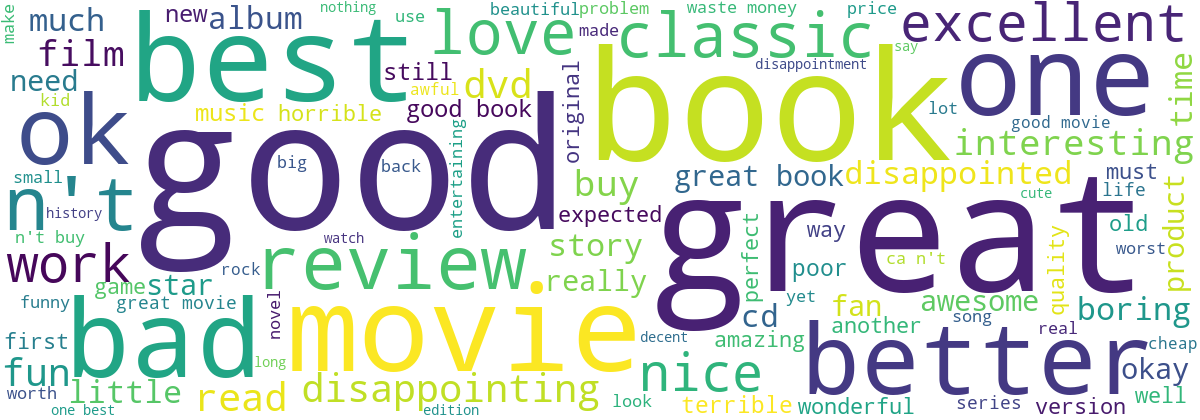

In [ ]:
titles_train = ','.join(list(train_titles_preprocessed.values))
wordcloud = WordCloud(max_words = 100, 
                      width = 1200, height = 420,
                      contour_width = 2, background_color = 'white')
wordcloud.generate(titles_train)
wordcloud.to_image()

*    Test data:

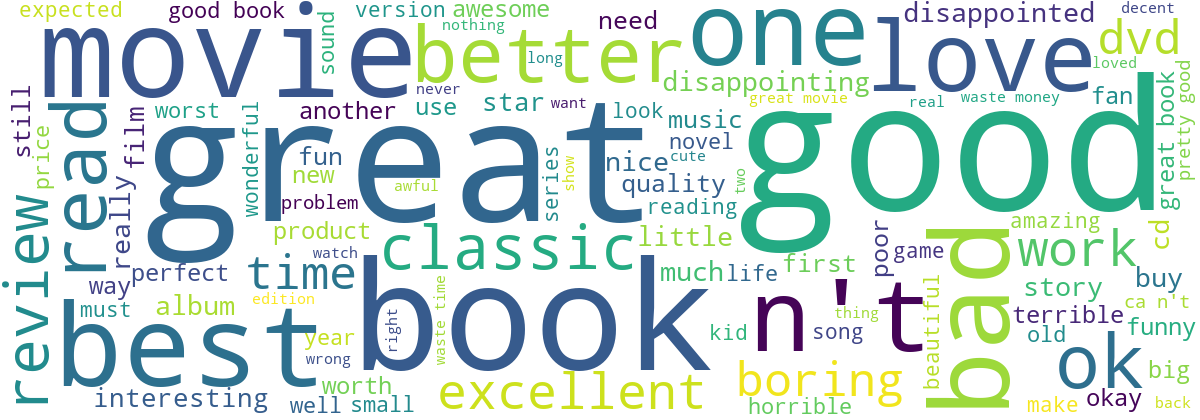

In [ ]:
titles_test = ','.join(list(test_titles_preprocessed.values))
wordcloud = WordCloud(max_words = 100, 
                      width = 1200, height = 420,
                      contour_width = 2, background_color = 'white')
wordcloud.generate(titles_test)
wordcloud.to_image()

WordCloud for Reviews' text:
*    Train data:

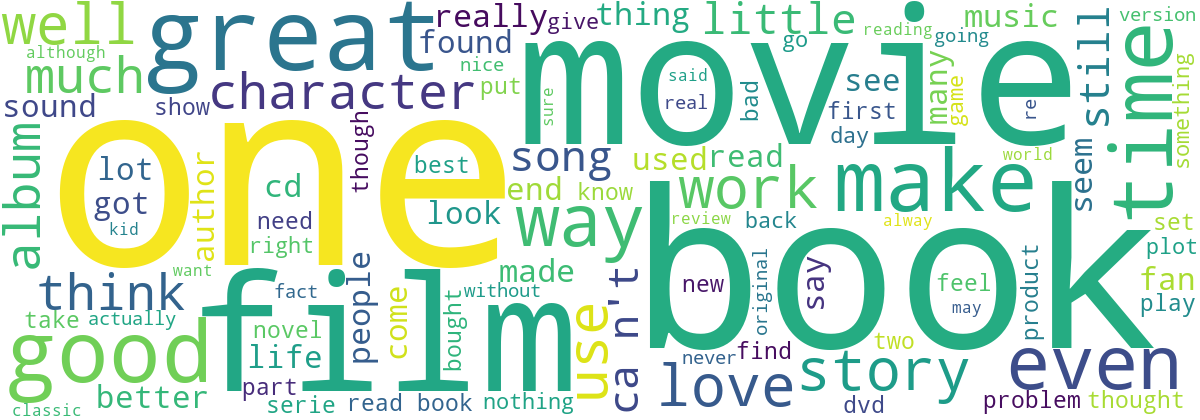

In [ ]:
reviews_train = ','.join(list(train_reviews_preprocessed.values))
wordcloud = WordCloud(max_words = 100, 
                      width = 1200, height = 420,
                      contour_width = 2, background_color = 'white')
wordcloud.generate(reviews_train)
wordcloud.to_image()

*    Test data:

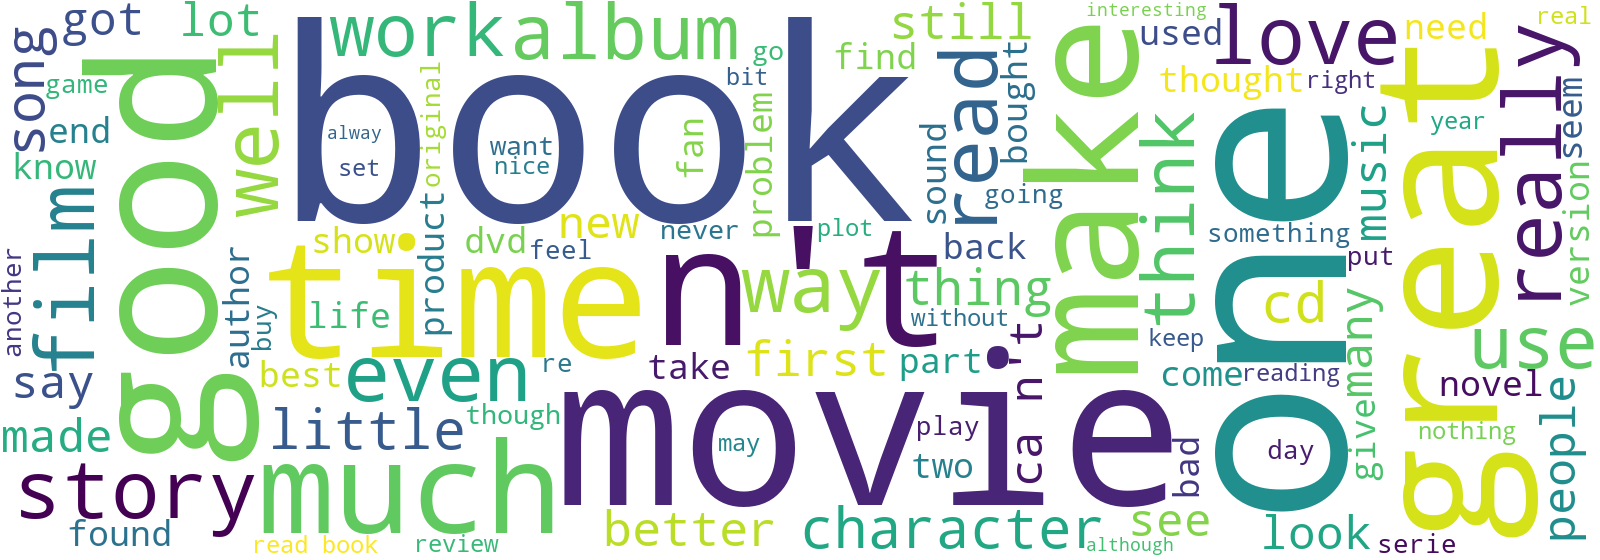

In [ ]:
reviews_test = ','.join(list(test_reviews_preprocessed.values))
wordcloud = WordCloud(max_words = 100, 
                      width = 1600,
                      height = 560,
                      contour_width = 2, background_color = 'white')
wordcloud.generate(reviews_test)
wordcloud.to_image()

In [ ]:
def get_top_ngrams(corpus, n, n_gram):
  count_vectorizer = CountVectorizer(stop_words='english',
                                     ngram_range=(n_gram, n_gram)).fit(corpus)
  bow = count_vectorizer.transform(corpus)
  sums = bow.sum(axis = 0)
  words_freq = [(word, sums[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

  return words_freq[:n]

When analysing textual data, it is common to make charts showing the frequency of words. This gives a good impression of what is talked about most in the reviews.

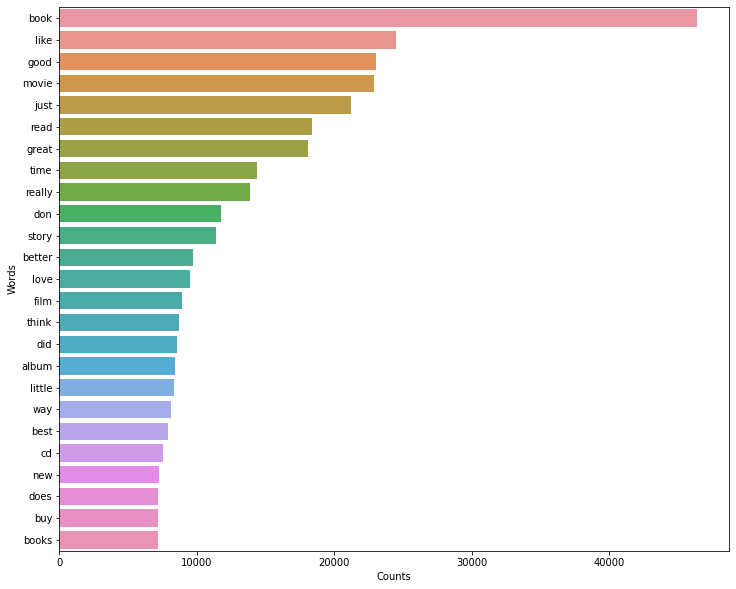

In [ ]:
most_common_words = get_top_ngrams(raw_train_data['Review'], 25, 1)

common_words_df = pd.DataFrame(most_common_words, columns = ['Words', 'Counts'])
plt.subplots(figsize = (12, 10))
sns.barplot(x = common_words_df['Counts'], y = common_words_df['Words'])

The advantage of examining the most frequent n-grams instead of the most frequent words is that it allows us to better understand the context in which the word was used.

#### Most frequent bigrams.

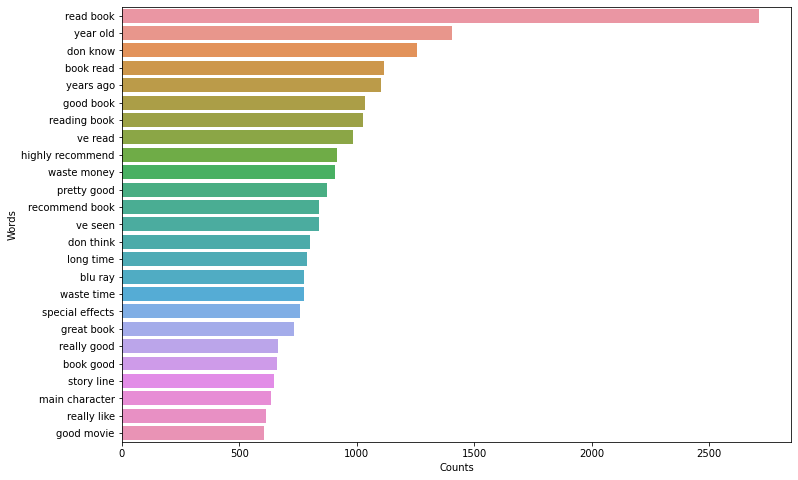

In [ ]:
most_common_bigrams = get_top_ngrams(raw_train_data['Review'], 25, 2)

common_bigrams_df = pd.DataFrame(most_common_bigrams, columns = ['Words', 'Counts'])
plt.subplots(figsize = (12, 8))
sns.barplot(x = common_bigrams_df['Counts'], y = common_bigrams_df['Words'])

#### Most frequent trigrams.

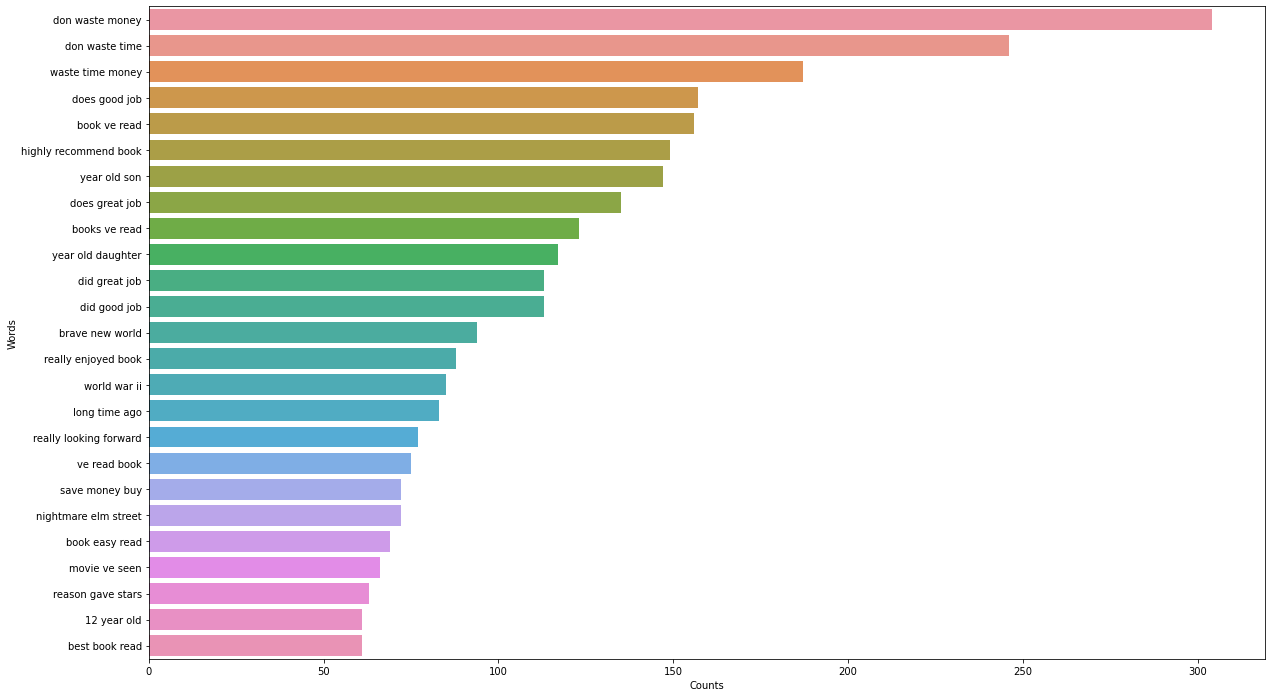

In [ ]:
most_common_trigrams = get_top_ngrams(raw_train_data['Review'], 25, 3)
common_trigrams_df = pd.DataFrame(most_common_trigrams, columns = ['Words', 'Counts'])

plt.subplots(figsize = (20, 12))
sns.barplot(x = common_trigrams_df['Counts'], y = common_trigrams_df['Words'])

### Topic modeling exploration

Topic modeling is an unsupervised learning technique used to extract the main topics from documents. We will use Latent Dirichlet Allocation algorithm to identify the main topics in the Reviews.

The main idea of Latent Dirichlet Allocation (LDA) is to model texts as arising from multiple topics, where a topic is defined by a distributionn on over a fixed vocabulary of terms from a given corpus. More concretely, we asume that K topics are associated.

The motivation for using this algorithm to identify the main topic of each review came from looking at the most common words, bi-grams, and tri-grams. Only from these, we could identify two important categories: movies and books.

Before applying the LDA algorithm we have to perform another stage of preprocessing on our data to be suitable for this algorithm:

1.   We filter out the stop words because they are common in any text, and they do not contain significant information for releaving topics.
2.   Another common pre-processing step is converting words to their "root" lexical forms (e.g., "politics" and "political" would be converted to "politic")
3.   Compute a vocabulary by giving an unique id to each word in the documents and then represent the textual data with a vector which contains the unique id instead of the respective words.
4.   Eliminate the tokens with a frequency equal to 1 from each document, as some tokens are not even real words or are rarely used in the corpus.



In [ ]:
reviews_train = raw_test_data['Review'].copy()

In [ ]:
reviews_train = reviews_train.apply(lambda x: ' '.join(word.translate(str.maketrans(' ', ' ', string.punctuation + string.digits)) \
                                                       for word in x.split() if word not in STOPWORDS))

In [ ]:
stemmer = PorterStemmer()

def stem_words(text):
  text = [stemmer.stem(word) for word in text.split(" ")]
  text = [word for word in text if len(word) > 1] # keep only words that have at least 2 characters

  return text

reviews_train = reviews_train.apply(lambda x: stem_words(x))

In [ ]:
# Build the vocabulary with all the words occurring in the documents
id_words = gensim.corpora.Dictionary(reviews_train)
bow_corpus = [id_words.doc2bow(doc) for doc in reviews_train]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       id2word = id_words,                                    
                                       passes = 10,
                                       workers = 3)
lda_model.show_topics()

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(85,
  '0.019*"zombi" + 0.011*"curl" + 0.011*"movement" + 0.009*"realli" + 0.008*"pretti" + 0.007*"origin" + 0.007*"like" + 0.006*"squeez" + 0.006*"think" + 0.006*"great"'),
 (93,
  '0.111*"version" + 0.024*"stori" + 0.010*"origin" + 0.009*"budget" + 0.008*"low" + 0.007*"appreci" + 0.007*"one" + 0.007*"edit" + 0.007*"real" + 0.007*"violenc"'),
 (19,
  '0.025*"floor" + 0.012*"are" + 0.010*"critiqu" + 0.010*"littl" + 0.008*"per" + 0.008*"colleg" + 0.008*"sax" + 0.008*"favor" + 0.008*"keurig" + 0.007*"step"'),
 (10,
  '0.018*"tv" + 0.013*"go" + 0.010*"move" + 0.009*"bad" + 0.009*"cant" + 0.008*"one" + 0.008*"ran" + 0.008*"wall" + 0.008*"time" + 0.008*"find"'),
 (69,
  '0.015*"use" + 0.011*"good" + 0.011*"tabl" + 0.010*"nice" + 0.009*"price" + 0.009*"bar" + 0.009*"like" + 0.009*"cut" + 0.009*"color" + 0.008*"get"'),
 (68,
  '0.025*"player" + 0.017*"screen" + 0.016*"sound" + 0.014*"it" + 0.013*"ipod" + 0.012*"wire" + 0.012*"button" + 0.011*"loud" + 0.010*"get" + 0.010*"turn"'),
 (17,
  '0.

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 15.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 50.5 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=2227cbdbc43ee43ca7af938b53ecc94576aeb072da5bab79aa7e8c9b958c3ea2
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompa

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id_words)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.215619 -0.133133       1        1  6.034580
98    -0.184167 -0.062204       2        1  5.791527
99    -0.147290 -0.024096       3        1  4.348888
72    -0.162650 -0.121010       4        1  3.307180
11    -0.164513  0.163061       5        1  3.243509
...         ...       ...     ...      ...       ...
67     0.128880  0.020452      96        1  0.361208
39     0.123883  0.121168      97        1  0.349852
29     0.152009  0.039620      98        1  0.325610
24     0.222963  0.001039      99        1  0.294257
56     0.217583 -0.000390     100        1  0.277713

[100 rows x 5 columns], topic_info=       Term          Freq         Total  Category  logprob  loglift
84     book  13316.000000  13316.000000   Default  30.0000  30.0000
212    movi   6411.000000   6411.000000   Default  29.0000  29.0000
43     read   6390.000000   6390.000000   Default  28.0000  28.0000
551   album   2449.000000   2449.000000   Default  27.0000  27.0000
498    song   2395.000000   2395.000000   Default  26.0000  26.0000
...     ...           ...           ...       ...      ...      ...
3749  hesit     14.438891     40.435944  Topic100  -5.0279   4.8565
2748    who     19.601983    148.082426  Topic100  -4.7222   3.8642
746   there     25.303370    755.310765  Topic100  -4.4669   2.4901
491   might     16.111934    638.914861  Topic100  -4.9183   2.2061
319    part     13.781128   1308.890353  Topic100  -5.0745   1.3327

[6791 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
48         5  0.801094     aa
48        27  0.040055     aa
48        32  0.080109     aa
48        38  0.040055     aa
48        45  0.040055     aa
...      ...       ...    ...
3235      27  0.029280   zoom
3235      49  0.732012   zoom
3235      94  0.029280   zoom
6348      93  0.809552   zorn
19674     70  0.847016  zorro

[38830 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 99, 100, 73, 12, 37, 97, 95, 21, 27, 87, 17, 29, 81, 32, 36, 71, 19, 85, 70, 14, 31, 60, 58, 7, 3, 84, 33, 54, 69, 11, 35, 5, 82, 43, 94, 24, 44, 89, 47, 65, 42, 88, 26, 46, 61, 52, 78, 22, 39, 59, 98, 75, 38, 45, 83, 41, 96, 9, 93, 2, 62, 72, 48, 74, 66, 56, 18, 16, 63, 77, 90, 86, 6, 76, 79, 80, 55, 20, 49, 23, 92, 53, 50, 10, 67, 15, 91, 4, 13, 8, 64, 34, 51, 28, 68, 40, 30, 25, 57])

### Count of Reviews for each Rating

In [ ]:
print('Count of Reviews for each Rating in the trainning dataset:\n',raw_train_data['Rating'].value_counts())

Count of Reviews for each Rating in the trainning dataset:
 3    16510
5    16373
4    16121
2    15997
1    14957
Name: Rating, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


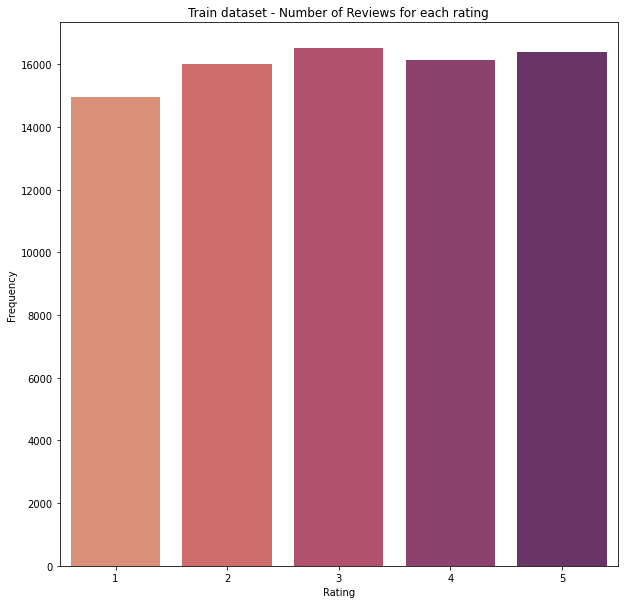

In [ ]:
plt.figure(figsize = (10, 10))
sns.countplot(raw_train_data['Rating'], palette = 'flare')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Train dataset - Number of Reviews for each rating")
plt.show()

In [ ]:
print('Count of Reviews for each Rating in the trainning dataset:\n',raw_test_data['Rating'].value_counts())

Count of Reviews for each Rating in the trainning dataset:
 3    4095
2    4080
5    4012
4    3979
1    3833
Name: Rating, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


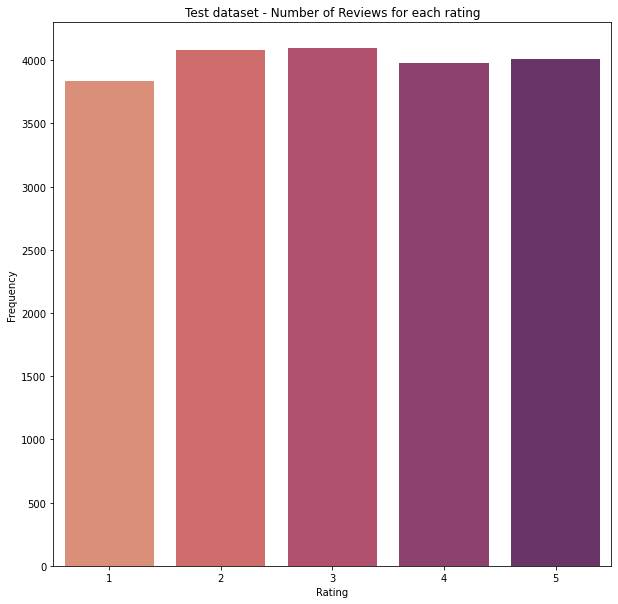

In [ ]:
plt.figure(figsize = (10, 10))
sns.countplot(raw_test_data['Rating'], palette = 'flare')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Test dataset - Number of Reviews for each rating")
plt.show()

We will transform the data for our task, three-point scale  (positive, neutral or negative sentiment towards that product review): 1 and 2 stars for negative, 3 for neutral and 4 and 5 for positive sentiment.

In [ ]:
sentiment_label = {0: 'negative', 1:'neutral', 2:'positive'}

conditions_train = [(raw_train_data['Rating'] <= 2),
                    (raw_train_data['Rating'] == 3),
                    (raw_train_data['Rating'] >= 4)]
conditions_test = [(raw_test_data['Rating'] <= 2),
                   (raw_test_data['Rating'] == 3),
                   (raw_test_data['Rating'] >= 4)]
assigned_labels = [0, 1, 2]

raw_train_data['Sentiment'] = np.select(conditions_train, assigned_labels)
raw_test_data['Sentiment'] = np.select(conditions_test, assigned_labels)

In [ ]:
# calculate the Spearman's correlation
corr, _ = spearmanr(review_len_rat_train_df['words_count_reviews'], raw_train_data['Sentiment'])
print("Spearman's correlation: %.3f" %corr)

Spearman's correlation: -0.072


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


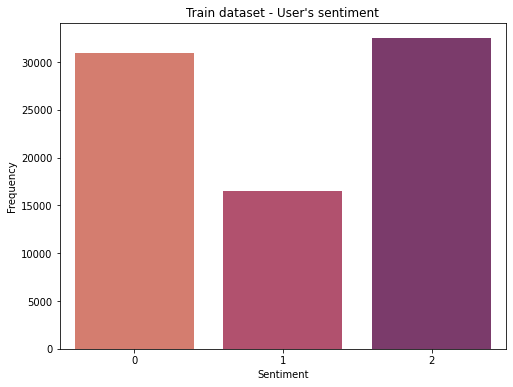

In [ ]:
plt.figure(figsize = (8, 6))
sns.countplot(raw_train_data['Sentiment'], palette = 'flare')
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Train dataset - User's sentiment")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


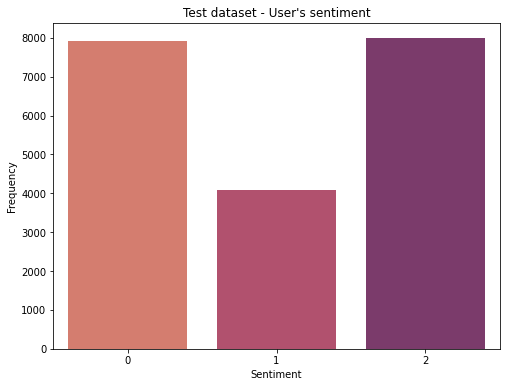

In [ ]:
plt.figure(figsize = (8, 6))
sns.countplot(raw_test_data['Sentiment'], palette = 'flare')
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Test dataset - User's sentiment")
plt.show()

We can conclude that we deal with an unbalanced dataset.

### Length of Reviews vs Rating

It will be interesting to see if the review length in terms of number of words changes with the rating and if it is any linear correlation between the review length and the rating.

In [ ]:
review_len_rat_train_df = raw_train_data[['Rating', 'words_count_reviews']]
review_len_rat_test_df = raw_test_data[['Rating', 'words_count_reviews']]

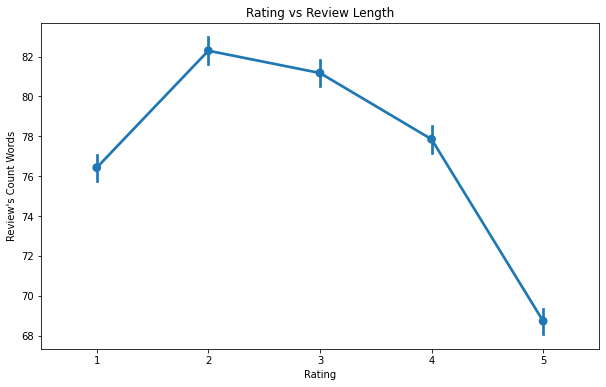

In [ ]:
plt.figure(figsize = (10, 6))
sns.pointplot(x = "Rating", y = "words_count_reviews", data = review_len_rat_train_df)
plt.xlabel("Rating")
plt.ylabel("Review's Count Words")
plt.title("Rating vs Review Length")
plt.show()

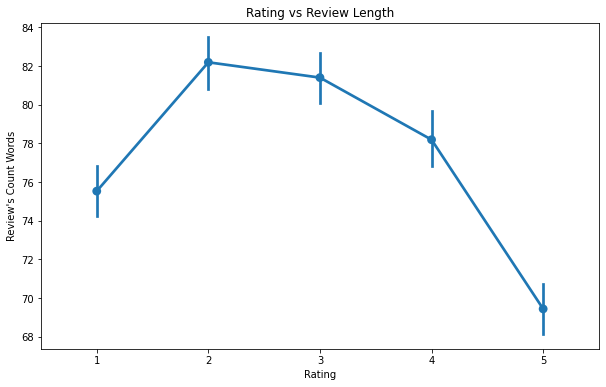

In [ ]:
plt.figure(figsize = (10, 6))
sns.pointplot(x = "Rating", y = "words_count_reviews", data = review_len_rat_test_df)
plt.xlabel("Rating")
plt.ylabel("Review's Count Words")
plt.title("Rating vs Review Length")
plt.show()

We can see that the tendency of users to write as little as possible when they are satisfied with the product.

## Model Building

### BERT (Bidirectional Encoder Representations from Transformers)

In [ ]:
class Parameters():
  def __init__(self):
    self.SEED = 42
    self.use_cuda = False
    self.batch_size = 64
    
    self.epochs = 10
    self.print_every = 15

#### Feature extraction

The data is pre-processed in two stages before extracting the textual features necessary in the following training steps. The first stage has been completed in the previous sections.

After finishing the first preprocessing step, the textual component of the Review is processed to match the input format expected by the BERT model. We eliminate all numeric and special characters except the period, question mark, and exclamation mark. Each text sequence is divided into individual language units, specific vocabulary tokens using the *BertTokenizer* method. In the same process, the uppercase characters are converted to lowercase characters.

Each input sequence begins with a [CLS] token, the embeddings of which are used for sentence-level classification. Similarly, each sequence ends with the [SEP] token. In the case of multi-sentence posts, an [SEP] token is inserted to separate the sentences. For example, the input sequence "Greetings Tweetarians !! I have just landed on your Planet." will be transformed in "['[CLS]', 'greeting', '##s', 't', '##wee', '##tarian', '##s', '!', '!', '[SEP]', 'i', 'have', 'just', 'landed', 'on', 'your', 'planet', '.', '[SEP]']".

It is necessary for each sequence to have the same dimensionality n', where n' is equal to 72, approximately the average number of words in a tweet plus the average number of tokens needed to separate the sentences. We also took into consideration that reviews with 5 stars ratings have small number of words. As a consequence, sequences containing fewer tokens are filled with the [PAD] token, and those containing more tokens are reduced to the first n'-1 tokens and the [SEP] token is appended at the end. We also do not want the end result to be influenced by the tokens used for padding. For this, we will use the attention mechanism of the BERT model, so that, when calculating the representations of each input token, no attention is given to the [PAD] tokens. We accomplish this by providing an attention mask along with distributed representations of words. The attention mask consists of a tensor that contains values of 0 for [PAD] tokens and 1 for the rest.

The last step of the second stage of textual data processing consists in replacing the tokens we obtained by following the above steps with their corresponding indices from the BERT vocabulary, obtaining a tensor i, with $ i \in R^{n \times d} $.




In [ ]:
special_characters = string.punctuation.replace("!", "").replace(".", "").replace("?", "") + string.digits

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y, max_length, device):
        self.X = np.array(X)
        self.y = np.array(y)
        self.max_length = max_length
        self.device = device

        # Initialize the BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def get_punctuation_indexes(self, tokens):
        indexes = []
        for idx, token in enumerate(tokens[:-1]):
            if token in string.punctuation and not tokens[idx + 1] in string.punctuation:
                indexes.append(idx)

        return indexes

    def add_special_tokens(self, tokens, punctuation_indexes):
        for i, index in enumerate(punctuation_indexes):
            tokens = tokens[:index + i + 1] + ['[SEP]'] + tokens[index + i + 1:]

        tokens = ['[CLS]'] + tokens + ['[SEP]']
        return tokens

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]

        # Pre-processing the data to be suitable for the BERT model
        tokens = self.tokenizer.tokenize(sample)
        indexes = self.get_punctuation_indexes(tokens)
        tokens = self.add_special_tokens(tokens, indexes)

        if len(tokens) < self.max_length:
            tokens = tokens + ['[PAD]' for _ in range(self.max_length - len(tokens))]
        else:
            tokens = tokens[:self.max_length-1] + ['[SEP]'] # Prunning the list to be of specified max length

        # Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
        tokens_ids = torch.tensor(tokens_ids, device=self.device) 

        # Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids != 0).long()
        attn_mask = torch.tensor(attn_mask, device=self.device)

        label = torch.tensor(label, device=self.device)

        return tokens_ids, attn_mask, label


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, freeze_bert = True, num_classes = 3):
    super(SentimentClassifier, self).__init__()
    
    self.bert_model = BertModel.from_pretrained('bert-base-uncased')

    # Freeze layers
    if freeze_bert:
      for params in self.bert_model.parameters():
        params.requires_grad = False

    # Classification layer
    self.linear = nn.Linear(768, num_classes)

  def forward(self, sequences, attn_masks):
    cont_reps = self.bert_model(sequences, attn_masks)
    cont_reps = cont_reps[0]

    cls_rep = cont_reps[:, 0]
    out = self.linear(cls_rep)
    return out

In [ ]:
def plot_losses(train_loss, val_loss, test_loss):
  plt.plot(train_loss, label = "Train Loss", color = "green")
  plt.plot(val_loss, label = "Validation Loss", color = "blue")
  plt.plot(test_loss, label = "Test Loss", color = "red")
  plt.legend()
  plt.show()

In [ ]:
def get_recall(tp, fn):        
  recall_negative = tp[0] / (tp[0] + fn[0] + 1e-5)
  recall_positive = tp[1] / (tp[1] + fn[1] + 1e-5)
  recall_neutral = tp[2] / (tp[2] + fn[2] + 1e-5)

  return [recall_negative, recall_neutral, recall_positive]


def get_avg_recall(recall):
  return np.sum(recall) / 3.0


def get_accuracy_from_logits(logits, labels):
  logs = logits.detach().to("cpu").numpy()
  logs = logs.argmax(axis=1)
  labels = labels.detach().to("cpu").numpy()
  accuracy = np.sum(logs == labels) / len(labels)
  
  return accuracy


def get_tp_fn_fp_from_logits(logits, labels):
  tp, fn , fp = [0, 0, 0], [0, 0, 0], [0, 0, 0]

  logs = logits.detach().to("cpu").numpy()
  labels = labels.detach().to("cpu").numpy()
  logs = logs.argmax(axis=1)
  try:
    logs = np.squeeze(logs)
  except ValueError:
    print('Can\'t squeeze shape: ', logs.shape)

  for (predicted, actual) in zip(logs, labels):
    actual = int(actual)
    if predicted == actual:
        tp[actual] += 1
    else:
        fp[predicted] += 1
        fn[actual] += 1

  return tp, fn, fp


def get_f1_pn(tp, fp, fn):
  recall_negative = tp[0] / (tp[0] + fn[0] + 1e-5)
  recall_positive = tp[1] / (tp[1] + fn[1] + 1e-5)

  precision_negative = tp[0] / (tp[0] + fp[0] + 1e-5)
  precision_positive = tp[1] / (tp[1] + fp[1] + 1e-5)

  f1_negative = 2. * (precision_negative * recall_negative) / (precision_negative + recall_negative + 1e-5)
  f1_positive = 2. * (precision_positive * recall_positive) / (precision_positive + recall_positive + 1e-5)

  f1_pn = .5 * (f1_negative + f1_positive)
  return f1_pn


def get_confusion_matrix(logits, labels):
  cf_matrix = confusion_matrix(logits, labels)
  return cf_matrix

In [ ]:
def run_text_sentiment_classifier(train_loader, validation_loader, test_loader, params, device):
    model = SentimentClassifier(freeze_bert=True).to(device)

    optimizer = AdamW(model.parameters(), lr=3e-5)

    train_loss, validation_loss, test_loss = [], [], []
    validation_accuracy, test_accuracy = [], []
    average_recall, f1_score_pn = [], []
    cf_matrix = None

    def evaluate(model, dataloader, cf_matrix):
        y_true, y_pred = [], []
        mean_acc, mean_loss = 0., 0.
        average_recall, f1_pn = 0., 0.
        count = 0

        model.eval()
        with torch.no_grad():
            for seq, attn_masks, labels in dataloader:
                logits = model(seq, attn_masks)
                mean_loss += F.cross_entropy(logits, labels.long()).item()
                mean_acc += get_accuracy_from_logits(logits, labels)
                tp, fn, fp = get_tp_fn_fp_from_logits(logits, labels)
                recall = get_recall(tp, fn)
                average_recall += get_avg_recall(recall)
                f1_pn += get_f1_pn(tp, fp, fn)

                logs = logits.clone().detach().to("cpu").numpy()
                logs = logs.argmax(axis = 1)
                labels = labels.clone().detach().to("cpu").numpy()

                y_pred.extend(logs)
                y_true.extend(labels)

                count += 1

        cf_matrix = get_confusion_matrix(y_pred, y_true)
        print(cf_matrix)
        return mean_acc / count, mean_loss / count, average_recall / count, f1_pn / count


    def train(model, optim, train_loader, val_loader, test_loader, cf_matrix):
        best_accuracy = 0.

        scheduler = ReduceLROnPlateau(optim, 'min', patience = 1)
        for epoch in range(params.epochs):
            model.train()

            batch_losses = 0.
            count = 0

            for it, (sequences, attn_masks, labels) in enumerate(train_loader):
                # Clear gradients
                optim.zero_grad()
                # Obtaining the logits from the model
                logits = model(sequences, attn_masks)
                # Handling the unbalanced dataset
                class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(labels.cpu().data.numpy()), y = labels.cpu().data.numpy())
                class_weights = torch.tensor(class_weights, dtype = torch.float, device=device)
                # Computing loss
                loss = F.cross_entropy(logits, labels.long(), weight=class_weights)
                loss = F.cross_entropy(logits, labels.long())

                # Backpropagation
                loss.backward()
                # Optimization step
                optim.step()

                batch_losses += loss.item()
                count += 1

                if (it + 1) % params.print_every == 0:
                    acc = get_accuracy_from_logits(logits, labels)
                    print("    Iteration {} of epoch {} completed. Loss : {} Accuracy : {:.2f}".format(it+1, epoch+1, loss.item(), acc * 100.))

            epoch_loss = batch_losses / count
            train_loss.append(epoch_loss)

            val_acc, val_loss, _, _ = evaluate(model, val_loader, cf_matrix)
            validation_loss.append(val_loss)
            validation_accuracy.append(val_acc)
            if val_acc > best_accuracy:
                print("Best validation accuracy improved from {} to {}, saving model...".format(best_accuracy, val_acc))
                best_accuracy = val_acc

            scheduler.step(val_loss)

            # Inference
            acc_test, loss_test, avg_recall, f1_pn = evaluate(model, test_loader, cf_matrix)
            print("Epoch {} completed. Evaluation measurements on test dataset:\n\t Loss: {} \n\t Accuracy : {:.2f} \
                \n\t Average recall: {:.4f} \n\t F1_PN: {:.4f}\n".format(epoch + 1, loss_test, acc_test * 100., avg_recall, f1_pn))
            test_accuracy.append(acc_test)
            test_loss.append(loss_test)
            average_recall.append(avg_recall)
            f1_score_pn.append(f1_pn)


    train(model, optimizer, train_loader, validation_loader, test_loader, cf_matrix)

    plot_losses(train_loss, validation_loss, test_loss)

In [ ]:
params: Parameters = Parameters()
params.use_cuda = torch.cuda.is_available()
params.epochs = 50
params.print_every = 200

np.random.seed(params.SEED)
torch.manual_seed(params.SEED)
torch.cuda.manual_seed_all(params.SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if params.use_cuda else {}

cuda


In [ ]:
X_train = raw_train_data['Review'].str.replace('[{}]'.format(special_characters), '')
X_test = raw_test_data['Review'].str.replace('[{}]'.format(special_characters), '')

In [ ]:
y_train = raw_train_data['Sentiment']
y_test = raw_test_data['Sentiment']

In [ ]:
# Split train dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [ ]:
dataset_train: TextDataset = TextDataset(X_train, y_train, 128, device)
dataset_val: TextDataset = TextDataset(X_val, y_val, 128, device)
dataset_test: TextDataset = TextDataset(X_test, y_test, 128, device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_loader = DataLoader(dataset_train, batch_size=params.batch_size)
val_loader = DataLoader(dataset_val, batch_size=params.batch_size)
test_loader = DataLoader(dataset_test, batch_size=params.batch_size)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone(

    Iteration 200 of epoch 1 completed. Loss : 1.008784532546997 Accuracy : 53.12
    Iteration 400 of epoch 1 completed. Loss : 0.9902172684669495 Accuracy : 56.25
    Iteration 600 of epoch 1 completed. Loss : 1.050596833229065 Accuracy : 53.12
    Iteration 800 of epoch 1 completed. Loss : 1.0068094730377197 Accuracy : 50.00
    Iteration 1000 of epoch 1 completed. Loss : 0.9818012118339539 Accuracy : 57.81
[[2314  832  688]
 [   0    0    0]
 [ 813  807 2542]]
Best validation accuracy improved from 0.0 to 0.6072833333333333, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[5814 2095 1826]
 [   0    2    1]
 [2099 1998 6164]]
Epoch 1 completed. Evaluation measurements on test dataset:
	 Loss: 0.9542630905160507 
	 Accuracy : 59.93                 
	 Average recall: 0.5008 
	 F1_PN: 0.3258



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 2 completed. Loss : 0.9092105031013489 Accuracy : 62.50
    Iteration 400 of epoch 2 completed. Loss : 0.9551857709884644 Accuracy : 59.38
    Iteration 600 of epoch 2 completed. Loss : 0.9704058766365051 Accuracy : 57.81
    Iteration 800 of epoch 2 completed. Loss : 0.9413275122642517 Accuracy : 57.81
    Iteration 1000 of epoch 2 completed. Loss : 0.9402725100517273 Accuracy : 59.38
[[2445  906  686]
 [   7    6    3]
 [ 675  727 2541]]
Best validation accuracy improved from 0.6072833333333333 to 0.6242833333333333, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6216 2227 1788]
 [  12   12    9]
 [1685 1856 6194]]
Epoch 2 completed. Evaluation measurements on test dataset:
	 Loss: 0.8954073763883914 
	 Accuracy : 62.13                 
	 Average recall: 0.5199 
	 F1_PN: 0.3418



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 3 completed. Loss : 0.8968865871429443 Accuracy : 68.75
    Iteration 400 of epoch 3 completed. Loss : 0.912585437297821 Accuracy : 60.94
    Iteration 600 of epoch 3 completed. Loss : 0.9361611008644104 Accuracy : 60.94
    Iteration 800 of epoch 3 completed. Loss : 0.9172977209091187 Accuracy : 56.25
    Iteration 1000 of epoch 3 completed. Loss : 0.9146555662155151 Accuracy : 62.50
[[2505  919  671]
 [  22   36   11]
 [ 600  684 2548]]
Best validation accuracy improved from 0.6242833333333333 to 0.6364249999999999, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6345 2226 1719]
 [  36   58   49]
 [1532 1811 6223]]
Epoch 3 completed. Evaluation measurements on test dataset:
	 Loss: 0.8625163578758606 
	 Accuracy : 63.15                 
	 Average recall: 0.5298 
	 F1_PN: 0.3574



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 4 completed. Loss : 0.8310842514038086 Accuracy : 65.62
    Iteration 400 of epoch 4 completed. Loss : 0.911764919757843 Accuracy : 57.81
    Iteration 600 of epoch 4 completed. Loss : 0.906860888004303 Accuracy : 57.81
    Iteration 800 of epoch 4 completed. Loss : 0.9272352457046509 Accuracy : 59.38
    Iteration 1000 of epoch 4 completed. Loss : 0.9003996849060059 Accuracy : 59.38
[[2507  888  641]
 [  37   66   20]
 [ 583  685 2569]]
Best validation accuracy improved from 0.6364249999999999 to 0.6430499999999999, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6372 2168 1620]
 [  74  116   93]
 [1467 1811 6278]]
Epoch 4 completed. Evaluation measurements on test dataset:
	 Loss: 0.8419831124738383 
	 Accuracy : 63.85                 
	 Average recall: 0.5383 
	 F1_PN: 0.3737



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 5 completed. Loss : 0.8796597123146057 Accuracy : 60.94
    Iteration 400 of epoch 5 completed. Loss : 0.8779857158660889 Accuracy : 64.06
    Iteration 600 of epoch 5 completed. Loss : 0.9351449608802795 Accuracy : 57.81
    Iteration 800 of epoch 5 completed. Loss : 0.898313581943512 Accuracy : 59.38
    Iteration 1000 of epoch 5 completed. Loss : 0.9103798866271973 Accuracy : 64.06
[[2513  868  639]
 [  48   99   30]
 [ 566  672 2561]]
Best validation accuracy improved from 0.6430499999999999 to 0.6469333333333332, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6386 2131 1597]
 [ 123  190  135]
 [1404 1774 6259]]
Epoch 5 completed. Evaluation measurements on test dataset:
	 Loss: 0.8276607597978732 
	 Accuracy : 64.19                 
	 Average recall: 0.5436 
	 F1_PN: 0.3894



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 6 completed. Loss : 0.8557230830192566 Accuracy : 65.62
    Iteration 400 of epoch 6 completed. Loss : 0.8867156505584717 Accuracy : 65.62
    Iteration 600 of epoch 6 completed. Loss : 0.8641563057899475 Accuracy : 60.94
    Iteration 800 of epoch 6 completed. Loss : 0.9520636200904846 Accuracy : 56.25
    Iteration 1000 of epoch 6 completed. Loss : 0.9275906085968018 Accuracy : 60.94
[[2514  846  614]
 [  62  120   48]
 [ 551  673 2568]]
Best validation accuracy improved from 0.6469333333333332 to 0.6505583333333332, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6381 2109 1572]
 [ 161  239  168]
 [1371 1747 6251]]
Epoch 6 completed. Evaluation measurements on test dataset:
	 Loss: 0.8175156613508352 
	 Accuracy : 64.37                 
	 Average recall: 0.5468 
	 F1_PN: 0.3984



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 7 completed. Loss : 0.8647090792655945 Accuracy : 60.94
    Iteration 400 of epoch 7 completed. Loss : 0.8827504515647888 Accuracy : 62.50
    Iteration 600 of epoch 7 completed. Loss : 0.9230396747589111 Accuracy : 54.69
    Iteration 800 of epoch 7 completed. Loss : 0.9099682569503784 Accuracy : 60.94
    Iteration 1000 of epoch 7 completed. Loss : 0.8331977725028992 Accuracy : 62.50
[[2529  848  607]
 [  66  133   61]
 [ 532  658 2562]]
Best validation accuracy improved from 0.6505583333333332 to 0.6533, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6386 2092 1566]
 [ 189  278  192]
 [1338 1725 6233]]
Epoch 7 completed. Evaluation measurements on test dataset:
	 Loss: 0.8098896435274484 
	 Accuracy : 64.50                 
	 Average recall: 0.5493 
	 F1_PN: 0.4053



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 8 completed. Loss : 0.8252813220024109 Accuracy : 67.19
    Iteration 400 of epoch 8 completed. Loss : 0.8588868379592896 Accuracy : 59.38
    Iteration 600 of epoch 8 completed. Loss : 0.8595337867736816 Accuracy : 57.81
    Iteration 800 of epoch 8 completed. Loss : 0.8764721155166626 Accuracy : 62.50
    Iteration 1000 of epoch 8 completed. Loss : 0.8557959198951721 Accuracy : 64.06
[[2525  848  601]
 [  70  138   66]
 [ 532  653 2563]]
Best validation accuracy improved from 0.6533 to 0.65355, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6377 2065 1542]
 [ 210  317  217]
 [1326 1713 6232]]
Epoch 8 completed. Evaluation measurements on test dataset:
	 Loss: 0.8040818054074297 
	 Accuracy : 64.65                 
	 Average recall: 0.5523 
	 F1_PN: 0.4128



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 9 completed. Loss : 0.8476206660270691 Accuracy : 62.50
    Iteration 400 of epoch 9 completed. Loss : 0.8559677004814148 Accuracy : 65.62
    Iteration 600 of epoch 9 completed. Loss : 0.8887228965759277 Accuracy : 59.38
    Iteration 800 of epoch 9 completed. Loss : 0.9001948833465576 Accuracy : 57.81
    Iteration 1000 of epoch 9 completed. Loss : 0.863205075263977 Accuracy : 59.38
[[2522  836  590]
 [  76  155   72]
 [ 529  648 2568]]
Best validation accuracy improved from 0.65355 to 0.655925, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6353 2028 1495]
 [ 230  350  241]
 [1330 1717 6255]]
Epoch 9 completed. Evaluation measurements on test dataset:
	 Loss: 0.799394114329792 
	 Accuracy : 64.81                 
	 Average recall: 0.5548 
	 F1_PN: 0.4189



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 10 completed. Loss : 0.845763623714447 Accuracy : 62.50
    Iteration 400 of epoch 10 completed. Loss : 0.9042048454284668 Accuracy : 62.50
    Iteration 600 of epoch 10 completed. Loss : 0.8627225756645203 Accuracy : 65.62
    Iteration 800 of epoch 10 completed. Loss : 0.8918864130973816 Accuracy : 60.94
    Iteration 1000 of epoch 10 completed. Loss : 0.8851313591003418 Accuracy : 54.69
[[2517  821  566]
 [  89  170   83]
 [ 521  648 2581]]
Best validation accuracy improved from 0.655925 to 0.6587999999999999, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6336 1983 1466]
 [ 249  383  258]
 [1328 1729 6267]]
Epoch 10 completed. Evaluation measurements on test dataset:
	 Loss: 0.7955834170499929 
	 Accuracy : 64.95                 
	 Average recall: 0.5572 
	 F1_PN: 0.4253



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 11 completed. Loss : 0.8623552918434143 Accuracy : 57.81
    Iteration 400 of epoch 11 completed. Loss : 0.8803336024284363 Accuracy : 65.62
    Iteration 600 of epoch 11 completed. Loss : 0.8723124265670776 Accuracy : 57.81
    Iteration 800 of epoch 11 completed. Loss : 0.8883747458457947 Accuracy : 62.50
    Iteration 1000 of epoch 11 completed. Loss : 0.8614844679832458 Accuracy : 57.81
[[2519  815  564]
 [  94  173   83]
 [ 514  651 2583]]
Best validation accuracy improved from 0.6587999999999999 to 0.6596749999999999, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6339 1971 1450]
 [ 257  398  264]
 [1317 1726 6277]]
Epoch 11 completed. Evaluation measurements on test dataset:
	 Loss: 0.7924427081601688 
	 Accuracy : 65.09                 
	 Average recall: 0.5590 
	 F1_PN: 0.4286



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 12 completed. Loss : 0.8241323232650757 Accuracy : 67.19
    Iteration 400 of epoch 12 completed. Loss : 0.8258813619613647 Accuracy : 62.50
    Iteration 600 of epoch 12 completed. Loss : 0.8838842511177063 Accuracy : 56.25
    Iteration 800 of epoch 12 completed. Loss : 0.9210538864135742 Accuracy : 56.25
    Iteration 1000 of epoch 12 completed. Loss : 0.8340696692466736 Accuracy : 67.19
[[2531  809  562]
 [  97  179   84]
 [ 499  651 2584]]
Best validation accuracy improved from 0.6596749999999999 to 0.6620583333333333, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6341 1967 1440]
 [ 265  412  271]
 [1307 1716 6280]]
Epoch 12 completed. Evaluation measurements on test dataset:
	 Loss: 0.7896559602155472 
	 Accuracy : 65.18                 
	 Average recall: 0.5604 
	 F1_PN: 0.4311



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 13 completed. Loss : 0.846822202205658 Accuracy : 65.62
    Iteration 400 of epoch 13 completed. Loss : 0.8205334544181824 Accuracy : 65.62
    Iteration 600 of epoch 13 completed. Loss : 0.884778618812561 Accuracy : 57.81
    Iteration 800 of epoch 13 completed. Loss : 0.9389277100563049 Accuracy : 56.25
    Iteration 1000 of epoch 13 completed. Loss : 0.8537443280220032 Accuracy : 64.06
[[2530  802  559]
 [ 104  199   90]
 [ 493  638 2581]]
Best validation accuracy improved from 0.6620583333333333 to 0.6640750000000001, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6332 1947 1421]
 [ 286  439  289]
 [1295 1709 6281]]
Epoch 13 completed. Evaluation measurements on test dataset:
	 Loss: 0.786995064336271 
	 Accuracy : 65.28                 
	 Average recall: 0.5622 
	 F1_PN: 0.4357



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 14 completed. Loss : 0.8881449699401855 Accuracy : 59.38
    Iteration 400 of epoch 14 completed. Loss : 0.9065502285957336 Accuracy : 64.06
    Iteration 600 of epoch 14 completed. Loss : 0.8710974454879761 Accuracy : 60.94
    Iteration 800 of epoch 14 completed. Loss : 0.8659178614616394 Accuracy : 59.38
    Iteration 1000 of epoch 14 completed. Loss : 0.8229074478149414 Accuracy : 62.50
[[2516  786  543]
 [ 108  210   93]
 [ 503  643 2594]]
Best validation accuracy improved from 0.6640750000000001 to 0.6653166666666667, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6292 1893 1379]
 [ 305  475  294]
 [1316 1727 6318]]
Epoch 14 completed. Evaluation measurements on test dataset:
	 Loss: 0.7851812913775825 
	 Accuracy : 65.44                 
	 Average recall: 0.5650 
	 F1_PN: 0.4418



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 15 completed. Loss : 0.8333929777145386 Accuracy : 67.19
    Iteration 400 of epoch 15 completed. Loss : 0.8651376366615295 Accuracy : 65.62
    Iteration 600 of epoch 15 completed. Loss : 0.8495007753372192 Accuracy : 62.50
    Iteration 800 of epoch 15 completed. Loss : 0.9262321591377258 Accuracy : 60.94
    Iteration 1000 of epoch 15 completed. Loss : 0.8578847646713257 Accuracy : 57.81
[[2532  798  550]
 [ 112  208   96]
 [ 483  633 2584]]
Best validation accuracy improved from 0.6653166666666667 to 0.665825, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6332 1921 1406]
 [ 306  472  292]
 [1275 1702 6293]]
Epoch 15 completed. Evaluation measurements on test dataset:
	 Loss: 0.7831664458631327 
	 Accuracy : 65.50                 
	 Average recall: 0.5654 
	 F1_PN: 0.4417



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 16 completed. Loss : 0.7928024530410767 Accuracy : 67.19
    Iteration 400 of epoch 16 completed. Loss : 0.833346426486969 Accuracy : 65.62
    Iteration 600 of epoch 16 completed. Loss : 0.8697620034217834 Accuracy : 59.38
    Iteration 800 of epoch 16 completed. Loss : 0.8768361806869507 Accuracy : 62.50
    Iteration 1000 of epoch 16 completed. Loss : 0.8703160881996155 Accuracy : 56.25
[[2541  801  550]
 [ 115  210   96]
 [ 471  628 2584]]
Best validation accuracy improved from 0.665825 to 0.6672, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6345 1916 1405]
 [ 313  485  297]
 [1255 1694 6289]]
Epoch 16 completed. Evaluation measurements on test dataset:
	 Loss: 0.7814136673086367 
	 Accuracy : 65.61                 
	 Average recall: 0.5668 
	 F1_PN: 0.4445



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 17 completed. Loss : 0.8586680293083191 Accuracy : 62.50
    Iteration 400 of epoch 17 completed. Loss : 0.8861666321754456 Accuracy : 65.62
    Iteration 600 of epoch 17 completed. Loss : 0.8257957696914673 Accuracy : 59.38
    Iteration 800 of epoch 17 completed. Loss : 0.8660123348236084 Accuracy : 64.06
    Iteration 1000 of epoch 17 completed. Loss : 0.8287571668624878 Accuracy : 65.62
[[2526  787  545]
 [ 115  211   96]
 [ 486  641 2589]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6326 1902 1384]
 [ 313  489  302]
 [1274 1704 6305]]
Epoch 17 completed. Evaluation measurements on test dataset:
	 Loss: 0.7800012975455092 
	 Accuracy : 65.62                 
	 Average recall: 0.5670 
	 F1_PN: 0.4447



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 18 completed. Loss : 0.8373525738716125 Accuracy : 65.62
    Iteration 400 of epoch 18 completed. Loss : 0.8414939641952515 Accuracy : 67.19
    Iteration 600 of epoch 18 completed. Loss : 0.8432645797729492 Accuracy : 60.94
    Iteration 800 of epoch 18 completed. Loss : 0.9215502142906189 Accuracy : 56.25
    Iteration 1000 of epoch 18 completed. Loss : 0.8655964732170105 Accuracy : 56.25
[[2529  783  541]
 [ 118  217   96]
 [ 480  639 2593]]
Best validation accuracy improved from 0.6672 to 0.6677000000000001, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6325 1894 1369]
 [ 322  506  309]
 [1266 1695 6313]]
Epoch 18 completed. Evaluation measurements on test dataset:
	 Loss: 0.7786696747469064 
	 Accuracy : 65.74                 
	 Average recall: 0.5689 
	 F1_PN: 0.4479



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 19 completed. Loss : 0.8155233263969421 Accuracy : 68.75
    Iteration 400 of epoch 19 completed. Loss : 0.8498707413673401 Accuracy : 64.06
    Iteration 600 of epoch 19 completed. Loss : 0.8070819973945618 Accuracy : 59.38
    Iteration 800 of epoch 19 completed. Loss : 0.9642514586448669 Accuracy : 54.69
    Iteration 1000 of epoch 19 completed. Loss : 0.8387455940246582 Accuracy : 60.94
[[2532  785  545]
 [ 116  212   98]
 [ 479  642 2587]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6339 1896 1370]
 [ 320  498  306]
 [1254 1701 6315]]
Epoch 19 completed. Evaluation measurements on test dataset:
	 Loss: 0.7774237577145854 
	 Accuracy : 65.78                 
	 Average recall: 0.5687 
	 F1_PN: 0.4471



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 20 completed. Loss : 0.7940177321434021 Accuracy : 71.88
    Iteration 400 of epoch 20 completed. Loss : 0.8763697743415833 Accuracy : 64.06
    Iteration 600 of epoch 20 completed. Loss : 0.8701207041740417 Accuracy : 60.94
    Iteration 800 of epoch 20 completed. Loss : 0.8775725364685059 Accuracy : 59.38
    Iteration 1000 of epoch 20 completed. Loss : 0.8721991777420044 Accuracy : 56.25
[[2521  778  533]
 [ 122  220  102]
 [ 484  641 2595]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6308 1867 1341]
 [ 338  529  319]
 [1267 1699 6331]]
Epoch 20 completed. Evaluation measurements on test dataset:
	 Loss: 0.7763308162887257 
	 Accuracy : 65.86                 
	 Average recall: 0.5706 
	 F1_PN: 0.4514



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 21 completed. Loss : 0.8542259931564331 Accuracy : 59.38
    Iteration 400 of epoch 21 completed. Loss : 0.8552612066268921 Accuracy : 68.75
    Iteration 600 of epoch 21 completed. Loss : 0.865778923034668 Accuracy : 60.94
    Iteration 800 of epoch 21 completed. Loss : 0.9153265953063965 Accuracy : 65.62
    Iteration 1000 of epoch 21 completed. Loss : 0.8712663650512695 Accuracy : 59.38
[[2520  774  533]
 [ 127  221  110]
 [ 480  644 2587]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6316 1866 1338]
 [ 348  548  323]
 [1249 1681 6330]]
Epoch 21 completed. Evaluation measurements on test dataset:
	 Loss: 0.7750742761090922 
	 Accuracy : 65.99                 
	 Average recall: 0.5724 
	 F1_PN: 0.4547



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 22 completed. Loss : 0.8518774509429932 Accuracy : 67.19
    Iteration 400 of epoch 22 completed. Loss : 0.8812178373336792 Accuracy : 64.06
    Iteration 600 of epoch 22 completed. Loss : 0.8711360692977905 Accuracy : 59.38
    Iteration 800 of epoch 22 completed. Loss : 0.910264253616333 Accuracy : 56.25
    Iteration 1000 of epoch 22 completed. Loss : 0.8775313496589661 Accuracy : 57.81
[[2523  778  532]
 [ 127  217  110]
 [ 477  644 2588]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6327 1874 1337]
 [ 340  542  323]
 [1246 1679 6331]]
Epoch 22 completed. Evaluation measurements on test dataset:
	 Loss: 0.7741122811366195 
	 Accuracy : 66.02                 
	 Average recall: 0.5724 
	 F1_PN: 0.4541



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 23 completed. Loss : 0.85810387134552 Accuracy : 60.94
    Iteration 400 of epoch 23 completed. Loss : 0.8424639701843262 Accuracy : 70.31
    Iteration 600 of epoch 23 completed. Loss : 0.8422718644142151 Accuracy : 64.06
    Iteration 800 of epoch 23 completed. Loss : 0.9079234004020691 Accuracy : 59.38
    Iteration 1000 of epoch 23 completed. Loss : 0.8781640529632568 Accuracy : 56.25
[[2519  780  530]
 [ 128  215  110]
 [ 480  644 2590]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6327 1862 1326]
 [ 346  557  329]
 [1240 1676 6336]]
Epoch 23 completed. Evaluation measurements on test dataset:
	 Loss: 0.7732064602093194 
	 Accuracy : 66.12                 
	 Average recall: 0.5738 
	 F1_PN: 0.4569



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 24 completed. Loss : 0.8414592146873474 Accuracy : 64.06
    Iteration 400 of epoch 24 completed. Loss : 0.8333922624588013 Accuracy : 65.62
    Iteration 600 of epoch 24 completed. Loss : 0.9080032706260681 Accuracy : 60.94
    Iteration 800 of epoch 24 completed. Loss : 0.8879052996635437 Accuracy : 56.25
    Iteration 1000 of epoch 24 completed. Loss : 0.8810053467750549 Accuracy : 60.94
[[2527  776  537]
 [ 135  228  114]
 [ 465  635 2579]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6338 1879 1339]
 [ 357  568  334]
 [1218 1648 6318]]
Epoch 24 completed. Evaluation measurements on test dataset:
	 Loss: 0.772045844088728 
	 Accuracy : 66.14                 
	 Average recall: 0.5740 
	 F1_PN: 0.4576



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 25 completed. Loss : 0.7981385588645935 Accuracy : 65.62
    Iteration 400 of epoch 25 completed. Loss : 0.8562659025192261 Accuracy : 60.94
    Iteration 600 of epoch 25 completed. Loss : 0.8956317901611328 Accuracy : 62.50
    Iteration 800 of epoch 25 completed. Loss : 0.9013718962669373 Accuracy : 54.69
    Iteration 1000 of epoch 25 completed. Loss : 0.8139693140983582 Accuracy : 64.06
[[2512  766  523]
 [ 141  233  114]
 [ 474  640 2593]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6313 1860 1308]
 [ 365  570  342]
 [1235 1665 6341]]
Epoch 25 completed. Evaluation measurements on test dataset:
	 Loss: 0.7714174441255319 
	 Accuracy : 66.14                 
	 Average recall: 0.5743 
	 F1_PN: 0.4580



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 26 completed. Loss : 0.828334629535675 Accuracy : 67.19
    Iteration 400 of epoch 26 completed. Loss : 0.8501335382461548 Accuracy : 64.06
    Iteration 600 of epoch 26 completed. Loss : 0.8706024289131165 Accuracy : 57.81
    Iteration 800 of epoch 26 completed. Loss : 0.8669045567512512 Accuracy : 59.38
    Iteration 1000 of epoch 26 completed. Loss : 0.8198214173316956 Accuracy : 60.94
[[2517  767  524]
 [ 136  230  114]
 [ 474  642 2592]]
Best validation accuracy improved from 0.6677000000000001 to 0.6677083333333333, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6324 1869 1308]
 [ 359  561  337]
 [1230 1665 6346]]
Epoch 26 completed. Evaluation measurements on test dataset:
	 Loss: 0.7707928390548633 
	 Accuracy : 66.17                 
	 Average recall: 0.5741 
	 F1_PN: 0.4568



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 27 completed. Loss : 0.8568341732025146 Accuracy : 64.06
    Iteration 400 of epoch 27 completed. Loss : 0.8467199206352234 Accuracy : 62.50
    Iteration 600 of epoch 27 completed. Loss : 0.8497840166091919 Accuracy : 59.38
    Iteration 800 of epoch 27 completed. Loss : 0.9124028086662292 Accuracy : 56.25
    Iteration 1000 of epoch 27 completed. Loss : 0.8056217432022095 Accuracy : 60.94
[[2519  767  524]
 [ 134  230  114]
 [ 474  642 2592]]
Best validation accuracy improved from 0.6677083333333333 to 0.6679583333333333, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6334 1872 1306]
 [ 356  562  337]
 [1223 1661 6348]]
Epoch 27 completed. Evaluation measurements on test dataset:
	 Loss: 0.7701304743465144 
	 Accuracy : 66.24                 
	 Average recall: 0.5747 
	 F1_PN: 0.4574



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 28 completed. Loss : 0.8139536380767822 Accuracy : 67.19
    Iteration 400 of epoch 28 completed. Loss : 0.8319375514984131 Accuracy : 70.31
    Iteration 600 of epoch 28 completed. Loss : 0.8684014081954956 Accuracy : 62.50
    Iteration 800 of epoch 28 completed. Loss : 0.9660664796829224 Accuracy : 60.94
    Iteration 1000 of epoch 28 completed. Loss : 0.8415140509605408 Accuracy : 64.06
[[2531  774  535]
 [ 134  234  117]
 [ 462  631 2578]]
Best validation accuracy improved from 0.6679583333333333 to 0.6682083333333334, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6358 1877 1332]
 [ 363  580  342]
 [1192 1638 6317]]
Epoch 28 completed. Evaluation measurements on test dataset:
	 Loss: 0.7690902609413806 
	 Accuracy : 66.29                 
	 Average recall: 0.5758 
	 F1_PN: 0.4603



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 29 completed. Loss : 0.8388640880584717 Accuracy : 64.06
    Iteration 400 of epoch 29 completed. Loss : 0.8696058392524719 Accuracy : 65.62
    Iteration 600 of epoch 29 completed. Loss : 0.8687554001808167 Accuracy : 57.81
    Iteration 800 of epoch 29 completed. Loss : 0.8888091444969177 Accuracy : 60.94
    Iteration 1000 of epoch 29 completed. Loss : 0.7881736755371094 Accuracy : 64.06
[[2518  759  524]
 [ 137  240  114]
 [ 472  640 2592]]
Best validation accuracy improved from 0.6682083333333334 to 0.6690833333333334, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6331 1865 1302]
 [ 369  581  342]
 [1213 1649 6347]]
Epoch 29 completed. Evaluation measurements on test dataset:
	 Loss: 0.7686838520982395 
	 Accuracy : 66.31                 
	 Average recall: 0.5761 
	 F1_PN: 0.4602



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 30 completed. Loss : 0.8335107564926147 Accuracy : 65.62
    Iteration 400 of epoch 30 completed. Loss : 0.8425171971321106 Accuracy : 68.75
    Iteration 600 of epoch 30 completed. Loss : 0.7697203755378723 Accuracy : 70.31
    Iteration 800 of epoch 30 completed. Loss : 0.8829154372215271 Accuracy : 65.62
    Iteration 1000 of epoch 30 completed. Loss : 0.8465011715888977 Accuracy : 60.94
[[2512  755  514]
 [ 141  240  118]
 [ 474  644 2598]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6311 1851 1289]
 [ 380  583  344]
 [1222 1661 6358]]
Epoch 30 completed. Evaluation measurements on test dataset:
	 Loss: 0.7681841101890174 
	 Accuracy : 66.27                 
	 Average recall: 0.5758 
	 F1_PN: 0.4599



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 31 completed. Loss : 0.7932860255241394 Accuracy : 64.06
    Iteration 400 of epoch 31 completed. Loss : 0.8063135147094727 Accuracy : 75.00
    Iteration 600 of epoch 31 completed. Loss : 0.8774877786636353 Accuracy : 56.25
    Iteration 800 of epoch 31 completed. Loss : 0.8943551182746887 Accuracy : 57.81
    Iteration 1000 of epoch 31 completed. Loss : 0.8216824531555176 Accuracy : 64.06
[[2518  764  518]
 [ 138  232  118]
 [ 471  643 2594]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6346 1870 1303]
 [ 360  573  344]
 [1207 1652 6344]]
Epoch 31 completed. Evaluation measurements on test dataset:
	 Loss: 0.76753336876726 
	 Accuracy : 66.33                 
	 Average recall: 0.5759 
	 F1_PN: 0.4594



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 32 completed. Loss : 0.8038244247436523 Accuracy : 64.06
    Iteration 400 of epoch 32 completed. Loss : 0.8981524705886841 Accuracy : 67.19
    Iteration 600 of epoch 32 completed. Loss : 0.8781084418296814 Accuracy : 59.38
    Iteration 800 of epoch 32 completed. Loss : 0.9229158759117126 Accuracy : 59.38
    Iteration 1000 of epoch 32 completed. Loss : 0.8266572952270508 Accuracy : 59.38
[[2505  749  505]
 [ 146  245  123]
 [ 476  645 2602]]
Best validation accuracy improved from 0.6690833333333334 to 0.6693333333333333, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6305 1839 1268]
 [ 385  601  363]
 [1223 1655 6360]]
Epoch 32 completed. Evaluation measurements on test dataset:
	 Loss: 0.7669177710438688 
	 Accuracy : 66.34                 
	 Average recall: 0.5771 
	 F1_PN: 0.4629



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 33 completed. Loss : 0.8954350352287292 Accuracy : 56.25
    Iteration 400 of epoch 33 completed. Loss : 0.9032039046287537 Accuracy : 68.75
    Iteration 600 of epoch 33 completed. Loss : 0.8386865258216858 Accuracy : 60.94
    Iteration 800 of epoch 33 completed. Loss : 0.9194234609603882 Accuracy : 57.81
    Iteration 1000 of epoch 33 completed. Loss : 0.8925357460975647 Accuracy : 53.12
[[2509  752  509]
 [ 144  245  121]
 [ 474  642 2600]]
Best validation accuracy improved from 0.6693333333333333 to 0.6695833333333334, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6319 1849 1278]
 [ 374  593  357]
 [1220 1653 6356]]
Epoch 33 completed. Evaluation measurements on test dataset:
	 Loss: 0.7664230755342843 
	 Accuracy : 66.35                 
	 Average recall: 0.5769 
	 F1_PN: 0.4619



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 34 completed. Loss : 0.829820454120636 Accuracy : 68.75
    Iteration 400 of epoch 34 completed. Loss : 0.8107489943504333 Accuracy : 64.06
    Iteration 600 of epoch 34 completed. Loss : 0.8228939771652222 Accuracy : 59.38
    Iteration 800 of epoch 34 completed. Loss : 0.9718036651611328 Accuracy : 57.81
    Iteration 1000 of epoch 34 completed. Loss : 0.8383613228797913 Accuracy : 59.38
[[2509  757  510]
 [ 140  235  120]
 [ 478  647 2600]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6323 1849 1277]
 [ 370  582  350]
 [1220 1664 6364]]
Epoch 34 completed. Evaluation measurements on test dataset:
	 Loss: 0.7660754482967024 
	 Accuracy : 66.36                 
	 Average recall: 0.5765 
	 F1_PN: 0.4605



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 35 completed. Loss : 0.8479853868484497 Accuracy : 60.94
    Iteration 400 of epoch 35 completed. Loss : 0.8766468167304993 Accuracy : 65.62
    Iteration 600 of epoch 35 completed. Loss : 0.8839930891990662 Accuracy : 60.94
    Iteration 800 of epoch 35 completed. Loss : 0.8972871899604797 Accuracy : 64.06
    Iteration 1000 of epoch 35 completed. Loss : 0.8504993319511414 Accuracy : 59.38
[[2500  744  500]
 [ 145  248  122]
 [ 482  647 2608]]
Best validation accuracy improved from 0.6695833333333334 to 0.6698333333333334, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6292 1831 1258]
 [ 393  599  359]
 [1228 1665 6374]]
Epoch 35 completed. Evaluation measurements on test dataset:
	 Loss: 0.7656631711572884 
	 Accuracy : 66.34                 
	 Average recall: 0.5770 
	 F1_PN: 0.4624



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 36 completed. Loss : 0.8044707775115967 Accuracy : 67.19
    Iteration 400 of epoch 36 completed. Loss : 0.9229262471199036 Accuracy : 60.94
    Iteration 600 of epoch 36 completed. Loss : 0.8444344997406006 Accuracy : 60.94
    Iteration 800 of epoch 36 completed. Loss : 0.942778468132019 Accuracy : 64.06
    Iteration 1000 of epoch 36 completed. Loss : 0.8529180288314819 Accuracy : 56.25
[[2523  755  517]
 [ 149  250  124]
 [ 455  634 2589]]
Best validation accuracy improved from 0.6698333333333334 to 0.6705833333333334, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6348 1863 1293]
 [ 385  611  368]
 [1180 1621 6330]]
Epoch 36 completed. Evaluation measurements on test dataset:
	 Loss: 0.7647087282646959 
	 Accuracy : 66.46                 
	 Average recall: 0.5784 
	 F1_PN: 0.4648



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 37 completed. Loss : 0.8610142469406128 Accuracy : 67.19
    Iteration 400 of epoch 37 completed. Loss : 0.86790931224823 Accuracy : 62.50
    Iteration 600 of epoch 37 completed. Loss : 0.8375918865203857 Accuracy : 67.19
    Iteration 800 of epoch 37 completed. Loss : 0.886171817779541 Accuracy : 54.69
    Iteration 1000 of epoch 37 completed. Loss : 0.8081192374229431 Accuracy : 67.19
[[2509  750  508]
 [ 155  252  126]
 [ 463  637 2596]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6308 1839 1270]
 [ 399  618  370]
 [1206 1638 6351]]
Epoch 37 completed. Evaluation measurements on test dataset:
	 Loss: 0.7644076632996337 
	 Accuracy : 66.40                 
	 Average recall: 0.5782 
	 F1_PN: 0.4653



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 38 completed. Loss : 0.9111610651016235 Accuracy : 62.50
    Iteration 400 of epoch 38 completed. Loss : 0.8203485608100891 Accuracy : 65.62
    Iteration 600 of epoch 38 completed. Loss : 0.8797414302825928 Accuracy : 60.94
    Iteration 800 of epoch 38 completed. Loss : 0.881115734577179 Accuracy : 62.50
    Iteration 1000 of epoch 38 completed. Loss : 0.8217352628707886 Accuracy : 60.94
[[2507  746  505]
 [ 154  251  124]
 [ 466  642 2601]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6307 1839 1268]
 [ 397  616  371]
 [1209 1640 6352]]
Epoch 38 completed. Evaluation measurements on test dataset:
	 Loss: 0.7640852128354886 
	 Accuracy : 66.39                 
	 Average recall: 0.5782 
	 F1_PN: 0.4653



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 39 completed. Loss : 0.8156778216362 Accuracy : 68.75
    Iteration 400 of epoch 39 completed. Loss : 0.8280702233314514 Accuracy : 64.06
    Iteration 600 of epoch 39 completed. Loss : 0.8482890725135803 Accuracy : 60.94
    Iteration 800 of epoch 39 completed. Loss : 0.929235577583313 Accuracy : 51.56
    Iteration 1000 of epoch 39 completed. Loss : 0.8604451417922974 Accuracy : 65.62
[[2510  750  507]
 [ 149  241  121]
 [ 468  648 2602]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6322 1847 1272]
 [ 382  595  356]
 [1209 1653 6363]]
Epoch 39 completed. Evaluation measurements on test dataset:
	 Loss: 0.7638137837568411 
	 Accuracy : 66.41                 
	 Average recall: 0.5776 
	 F1_PN: 0.4629



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 40 completed. Loss : 0.8363363742828369 Accuracy : 62.50
    Iteration 400 of epoch 40 completed. Loss : 0.9130755662918091 Accuracy : 56.25
    Iteration 600 of epoch 40 completed. Loss : 0.8669227361679077 Accuracy : 57.81
    Iteration 800 of epoch 40 completed. Loss : 0.8737254738807678 Accuracy : 56.25
    Iteration 1000 of epoch 40 completed. Loss : 0.8908973932266235 Accuracy : 60.94
[[2505  740  506]
 [ 154  248  123]
 [ 468  651 2601]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6309 1835 1264]
 [ 400  611  365]
 [1204 1649 6362]]
Epoch 40 completed. Evaluation measurements on test dataset:
	 Loss: 0.7633633345079879 
	 Accuracy : 66.42                 
	 Average recall: 0.5782 
	 F1_PN: 0.4647



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 41 completed. Loss : 0.868977963924408 Accuracy : 62.50
    Iteration 400 of epoch 41 completed. Loss : 0.8155088424682617 Accuracy : 67.19
    Iteration 600 of epoch 41 completed. Loss : 0.9087862372398376 Accuracy : 57.81
    Iteration 800 of epoch 41 completed. Loss : 0.8799507021903992 Accuracy : 60.94
    Iteration 1000 of epoch 41 completed. Loss : 0.8718809485435486 Accuracy : 62.50
[[2512  743  503]
 [ 155  252  127]
 [ 460  644 2600]]
Best validation accuracy improved from 0.6705833333333334 to 0.6708416666666667, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6304 1834 1263]
 [ 412  617  364]
 [1197 1644 6364]]
Epoch 41 completed. Evaluation measurements on test dataset:
	 Loss: 0.7628341551405934 
	 Accuracy : 66.44                 
	 Average recall: 0.5786 
	 F1_PN: 0.4651



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 42 completed. Loss : 0.8261611461639404 Accuracy : 65.62
    Iteration 400 of epoch 42 completed. Loss : 0.9108901619911194 Accuracy : 62.50
    Iteration 600 of epoch 42 completed. Loss : 0.8012335896492004 Accuracy : 60.94
    Iteration 800 of epoch 42 completed. Loss : 0.9177719354629517 Accuracy : 60.94
    Iteration 1000 of epoch 42 completed. Loss : 0.7820246815681458 Accuracy : 64.06
[[2519  748  508]
 [ 151  245  126]
 [ 457  646 2596]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6327 1844 1267]
 [ 394  607  368]
 [1192 1644 6356]]
Epoch 42 completed. Evaluation measurements on test dataset:
	 Loss: 0.7624967564790013 
	 Accuracy : 66.46                 
	 Average recall: 0.5784 
	 F1_PN: 0.4644



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 43 completed. Loss : 0.8090588450431824 Accuracy : 65.62
    Iteration 400 of epoch 43 completed. Loss : 0.8151311278343201 Accuracy : 67.19
    Iteration 600 of epoch 43 completed. Loss : 0.8001726865768433 Accuracy : 59.38
    Iteration 800 of epoch 43 completed. Loss : 0.8947877883911133 Accuracy : 59.38
    Iteration 1000 of epoch 43 completed. Loss : 0.8185635209083557 Accuracy : 62.50
[[2506  736  499]
 [ 165  255  127]
 [ 456  648 2604]]
Best validation accuracy improved from 0.6708416666666667 to 0.6709666666666667, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6293 1827 1252]
 [ 417  619  377]
 [1203 1649 6362]]
Epoch 43 completed. Evaluation measurements on test dataset:
	 Loss: 0.76219958828661 
	 Accuracy : 66.38                 
	 Average recall: 0.5783 
	 F1_PN: 0.4651



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 44 completed. Loss : 0.8781123161315918 Accuracy : 68.75
    Iteration 400 of epoch 44 completed. Loss : 0.8494719862937927 Accuracy : 64.06
    Iteration 600 of epoch 44 completed. Loss : 0.8883529305458069 Accuracy : 59.38
    Iteration 800 of epoch 44 completed. Loss : 0.9370395541191101 Accuracy : 59.38
    Iteration 1000 of epoch 44 completed. Loss : 0.8250629305839539 Accuracy : 62.50
[[2513  741  501]
 [ 161  249  126]
 [ 453  649 2603]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6311 1834 1255]
 [ 405  617  372]
 [1197 1644 6364]]
Epoch 44 completed. Evaluation measurements on test dataset:
	 Loss: 0.7618813859388089 
	 Accuracy : 66.47                 
	 Average recall: 0.5790 
	 F1_PN: 0.4658



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 45 completed. Loss : 0.8463122844696045 Accuracy : 65.62
    Iteration 400 of epoch 45 completed. Loss : 0.8275691270828247 Accuracy : 70.31
    Iteration 600 of epoch 45 completed. Loss : 0.9262733459472656 Accuracy : 60.94
    Iteration 800 of epoch 45 completed. Loss : 0.9138615727424622 Accuracy : 56.25
    Iteration 1000 of epoch 45 completed. Loss : 0.840584933757782 Accuracy : 60.94
[[2517  742  505]
 [ 164  255  128]
 [ 446  642 2597]]
Best validation accuracy improved from 0.6709666666666667 to 0.6714666666666667, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6333 1841 1267]
 [ 412  632  385]
 [1168 1622 6339]]
Epoch 45 completed. Evaluation measurements on test dataset:
	 Loss: 0.7612669475543232 
	 Accuracy : 66.53                 
	 Average recall: 0.5800 
	 F1_PN: 0.4679



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 46 completed. Loss : 0.7822228074073792 Accuracy : 68.75
    Iteration 400 of epoch 46 completed. Loss : 0.8521208167076111 Accuracy : 67.19
    Iteration 600 of epoch 46 completed. Loss : 0.8896063566207886 Accuracy : 59.38
    Iteration 800 of epoch 46 completed. Loss : 0.8825174570083618 Accuracy : 64.06
    Iteration 1000 of epoch 46 completed. Loss : 0.8658980131149292 Accuracy : 62.50
[[2511  739  497]
 [ 160  250  126]
 [ 456  650 2607]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6310 1826 1245]
 [ 402  615  367]
 [1201 1654 6379]]
Epoch 46 completed. Evaluation measurements on test dataset:
	 Loss: 0.7612840116214448 
	 Accuracy : 66.53                 
	 Average recall: 0.5796 
	 F1_PN: 0.4660



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 47 completed. Loss : 0.7906051278114319 Accuracy : 64.06
    Iteration 400 of epoch 47 completed. Loss : 0.8519701361656189 Accuracy : 67.19
    Iteration 600 of epoch 47 completed. Loss : 0.8570550084114075 Accuracy : 64.06
    Iteration 800 of epoch 47 completed. Loss : 0.8354026675224304 Accuracy : 70.31
    Iteration 1000 of epoch 47 completed. Loss : 0.865227222442627 Accuracy : 60.94
[[2525  749  507]
 [ 154  242  123]
 [ 448  648 2600]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6342 1853 1263]
 [ 394  610  364]
 [1177 1632 6364]]
Epoch 47 completed. Evaluation measurements on test dataset:
	 Loss: 0.760910310113011 
	 Accuracy : 66.59                 
	 Average recall: 0.5799 
	 F1_PN: 0.4658



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 48 completed. Loss : 0.8267012238502502 Accuracy : 67.19
    Iteration 400 of epoch 48 completed. Loss : 0.8667117953300476 Accuracy : 62.50
    Iteration 600 of epoch 48 completed. Loss : 0.8098549246788025 Accuracy : 60.94
    Iteration 800 of epoch 48 completed. Loss : 0.895106852054596 Accuracy : 57.81
    Iteration 1000 of epoch 48 completed. Loss : 0.8230968713760376 Accuracy : 62.50
[[2524  746  505]
 [ 155  249  130]
 [ 448  644 2595]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6335 1846 1262]
 [ 405  626  376]
 [1173 1623 6353]]
Epoch 48 completed. Evaluation measurements on test dataset:
	 Loss: 0.7604312959570474 
	 Accuracy : 66.58                 
	 Average recall: 0.5802 
	 F1_PN: 0.4675



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 49 completed. Loss : 0.844416618347168 Accuracy : 65.62
    Iteration 400 of epoch 49 completed. Loss : 0.8870079517364502 Accuracy : 64.06
    Iteration 600 of epoch 49 completed. Loss : 0.8128384947776794 Accuracy : 65.62
    Iteration 800 of epoch 49 completed. Loss : 0.8769620060920715 Accuracy : 60.94
    Iteration 1000 of epoch 49 completed. Loss : 0.8303137421607971 Accuracy : 62.50
[[2521  742  500]
 [ 155  250  128]
 [ 451  647 2602]]
Best validation accuracy improved from 0.6714666666666667 to 0.6719666666666667, saving model...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6320 1835 1245]
 [ 411  631  376]
 [1182 1629 6370]]
Epoch 49 completed. Evaluation measurements on test dataset:
	 Loss: 0.7602453656470813 
	 Accuracy : 66.62                 
	 Average recall: 0.5809 
	 F1_PN: 0.4684



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


    Iteration 200 of epoch 50 completed. Loss : 0.862916886806488 Accuracy : 60.94
    Iteration 400 of epoch 50 completed. Loss : 0.825103223323822 Accuracy : 70.31
    Iteration 600 of epoch 50 completed. Loss : 0.8260063529014587 Accuracy : 67.19
    Iteration 800 of epoch 50 completed. Loss : 0.8977046608924866 Accuracy : 57.81
    Iteration 1000 of epoch 50 completed. Loss : 0.8111380338668823 Accuracy : 65.62
[[2518  741  499]
 [ 160  250  133]
 [ 449  648 2598]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[6324 1828 1247]
 [ 415  640  380]
 [1174 1627 6364]]
Epoch 50 completed. Evaluation measurements on test dataset:
	 Loss: 0.7600474591834095 
	 Accuracy : 66.65                 
	 Average recall: 0.5817 
	 F1_PN: 0.4698



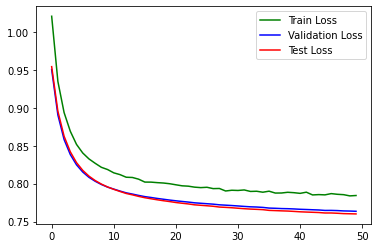

In [ ]:
run_text_sentiment_classifier(train_loader, val_loader, test_loader, params, device)

In [ ]:
cf_matrix = [[6324, 1828, 1247],
 [415,  640,  380],
 [1174, 1627, 6364]]

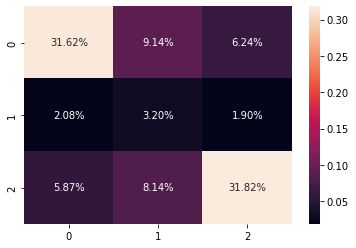

In [ ]:
sns.heatmap(cf_matrix / np.sum(cf_matrix),
            fmt = '.2%',
            annot = True)

## Results

### Evaluation metrics

The main measures for evaluating the model are $ accuracy $ and $ F_1^{PN} $. The last one is the average of the  values calculated for the positive and negative classes, respectively. It is calculated as follows:
$$ F_1^{PN} = \frac{1}{2}(F_1^N + F_1^P)  $$

Moving forward, we use the average recall value as a secondary measure to evaluate the model, because this measure has the desirable theoretical properties for this task. It is calculated as follows:

$$ AvgRec = \frac{1}{3}(R^N + R^U + R^P) $$

where , $ R^N $, $ R^U $, and $ R^P $ are the recall values for the NEGATIVE, NEUTRAL and POSITIVE classes, which is also sensitive to class imbalance.

The advantage of the $ AvgRec $ value over the standard accuracy is that it is more robust to the class imbalance. The accuracy of the majority class classifier is the relative frequency, known as the majority class prevalence, which can be greater than 0.5 if the test set is highly unbalanced. Another advantage of AvgRec over F1 is that AvgRec is invariant in switching the POSITIVE class with the NEGATIVE class, while $ F_1^{PN} $ is not.

